In [1]:
import numpy as np

import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import brainscore
neural_data = brainscore.get_assembly("dicarlo.MajajHong2015.public")

/home/bsorsch/.py37/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Loading lookup from /home/bsorsch/.py37/lib/python3.7/site-packages/brainio_collection/lookup.csv


In [4]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

# Helper functions

In [1251]:
# Compute error
m = 5
n_avg = 2000

def compute_err(manifolds,m):
    err_all = np.zeros((len(manifolds),len(manifolds)))
    err_std = np.zeros((len(manifolds),len(manifolds)))
    for a in tqdm(range(len(manifolds))):
        Xa = manifolds[a]
        for b in range(len(manifolds)):
            Xb = manifolds[b]

            errs = []
            for _ in range(n_avg):
                perma = np.random.permutation(len(Xa))
                permb = np.random.permutation(len(Xb))

                xa,ya = np.split(Xa[perma],(m,))
                xb,yb = np.split(Xb[permb],(m,))
                w = (xa-xb).mean(0)
                mu = (xa+xb).mean(0)/2

                h = ya@w - w@mu
                err = (h<0).mean()
                errs.append(err)
            err_all[a,b] = np.mean(errs)
            err_std[a,b] = np.std(errs)
    np.fill_diagonal(err_all,np.nan)
    
    return err_all, err_std




def geometry(centers,Rs,Us,m):
    K = len(centers)
    P = Rs.shape[1]
    dists = np.sqrt(((centers[:,None] - centers[None])**2).sum(-1))
    dist_norm = dists / np.sqrt((Rs**2).sum(-1)[:,None] / P)

    Ds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)

    # Center-subspace
    csa = []
    csb = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())
            else:
                csa.append(np.nan)
                csb.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)

    # Subspace-subspace
    ss = []
    for a in range(K):
        for b in range(K):
            if a!=b:
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                ss.append(np.nan)
    ss = np.stack(ss).reshape(K,K)

    css = (csa + csb/m) * dist_norm**2

    bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
    SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds[:,None]/m + css + ss/m)
    
    return dist_norm, Ds, csa, ss, SNR

# IT

In [1327]:
compact_data = neural_data.multi_groupby(
    ['category_name', 'object_name', 'image_id']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)

/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: list(self.group_coord_names)})


In [1328]:
# Keep only medium-variation manifolds
image_ids = compact_data['image_id'].values
stim_image_ids = stimulus_set['image_id'].values
medvar_idxs = []
for i,imid in enumerate(image_ids):
    stimid = np.where(stim_image_ids==imid)[0][0]
    if stimid >= 640:
        medvar_idxs.append(i)
compact_data = compact_data[medvar_idxs]

In [1329]:
class_labels = compact_data['category_name'].values
labels = compact_data['object_name'].values

In [1330]:
uniq_classes = np.unique(class_labels)
uniq_labels,idxs = np.unique(labels, return_index=True)
uniq_labels = uniq_labels[np.argsort(idxs)]
print(uniq_labels)

['bear' 'cow' 'dog' 'elephant' 'gorilla' 'hedgehog' 'lioness' 'turtle'
 'ship0' 'ship1' 'ship2' 'ship3' 'ship4' 'ship5' 'ship6' 'ship7'
 'car_alfa' 'car_astra' 'car_beetle' 'car_bmw' 'car_bora' 'car_celica'
 'car_clio' 'car_z3' 'chair0' 'chair1' 'chair2' 'chair3' 'chair4' 'chair5'
 'chair6' 'chair7' 'face0' 'face1' 'face2' 'face3' 'face4' 'face5' 'face6'
 'face7' 'apple' 'apricot' 'peach' 'pear' 'raspberry' 'strawberry'
 'walnut' 'watermelon' 'airplane0' 'airplane1' 'airplane2' 'airplane3'
 'airplane4' 'airplane5' 'airplane6' 'airplane7' 'table0' 'table1'
 'table2' 'table3' 'table4' 'table5' 'table6' 'table7']


In [1331]:
class_idxs = []
for lbl in uniq_labels:
    class_idxs.append(np.where(np.stack(labels)==lbl)[0])

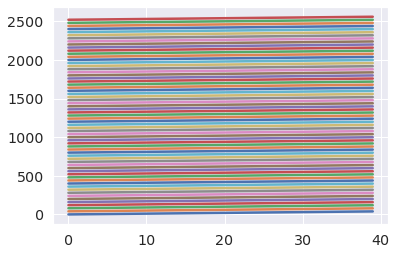

In [1332]:
for ci in class_idxs:
    plt.plot(ci)

In [1333]:
features = compact_data.values

manifolds = []
for ci in class_idxs:
    manifolds.append(features[ci])
manifolds = np.stack(manifolds)

In [1334]:
# # Try z-scoring
# mu = manifolds.mean((0,1))
# std = manifolds.std((0,1))

# manifolds = (manifolds - mu) / std

In [1335]:
Rs = []
centers = []
Us = []
for manifold in manifolds:
    centers.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs.append(R)
    Us.append(V)
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

In [1336]:
m = 5
dist_norm_IT, Ds_IT, csa_IT, ss_IT, SNR_IT = geometry(centers,Rs,Us,m)

In [1128]:
print(Ds_IT)

[ 9.448387   7.167786   7.4778094  7.8004017  9.84215   10.108062
  7.5659733 10.890192  14.598827  11.918094   9.340222  10.762592
 10.136131  11.139927  12.0846615 11.688347  11.023741  11.859203
  9.145635  11.6743145 12.302539  12.449412  12.574239  10.487455
  6.932081   8.383468   8.523343  10.1709175  6.2303905  8.328556
  8.610106   8.84035    6.5673866  8.871012   7.900409   7.2735386
  7.6334705  7.343354   6.30182    9.193745  11.630197  10.562501
 10.158674   8.816648   8.852413   7.9529843  7.7002754  6.1582623
  9.37338    9.192939   9.846468  11.383087   9.506922   8.518644
 10.853292  10.265154   8.1679125  7.9603643  9.178912  13.261907
 12.333975   9.187552   9.449662  10.470457 ]


In [1151]:
err_IT, err_std_IT = compute_err(manifolds,m)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.8442610945767196


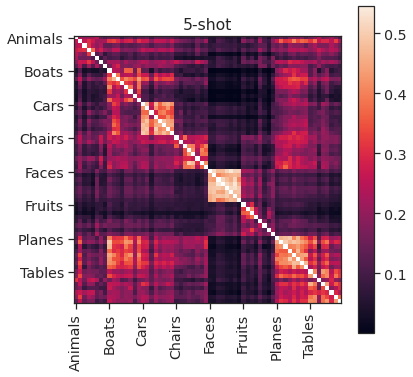

In [450]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    plt.imshow(err_IT)
    plt.xticks(np.arange(len(uniq_classes))*8,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8,list(uniq_classes))
    plt.colorbar()
    plt.title(str(m) +'-shot')
    # plt.axis('off')
print(1-np.nanmean(err_IT))

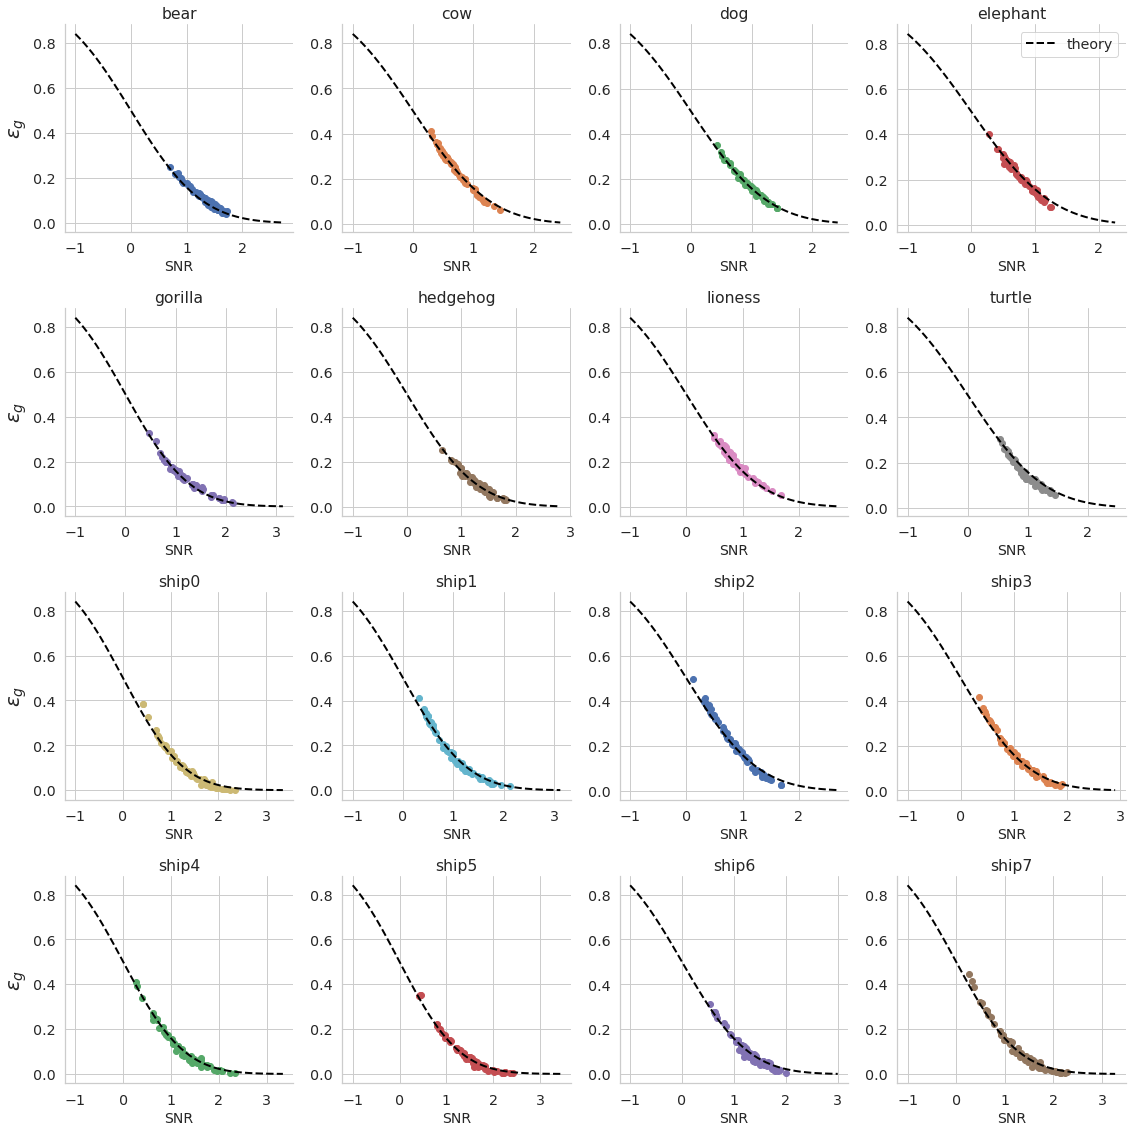

In [1302]:
n_plots = 16
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.errorbar(SNR_IT[i], err_IT[i],
                 yerr=err_std_IT[i]/np.sqrt(n_avg)*3, fmt='o', c='C' + str(c%10))
        plt.title(uniq_labels[i])
#         plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR_IT[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory', zorder=99)

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.tight_layout()

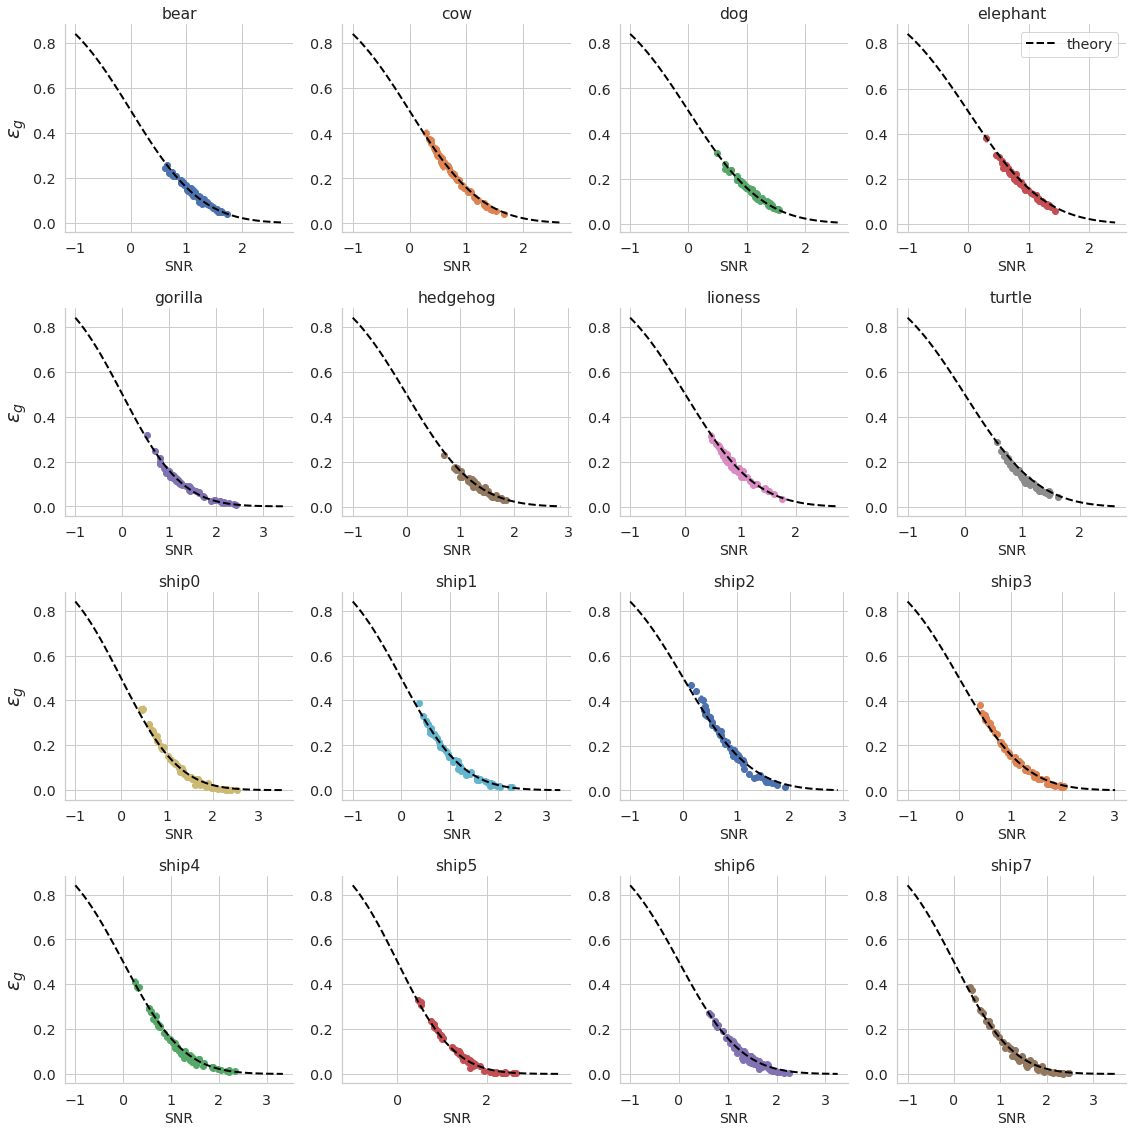

In [466]:
n_plots = 16
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.errorbar(SNR_IT[i], err_IT[i],
                 yerr=err_std_IT[i]/np.sqrt(n_avg)*3, fmt='o', c='C' + str(c%10))
        plt.title(uniq_labels[i])
#         plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR_IT[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory', zorder=99)

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.tight_layout()

In [467]:
bias = (Rs**2).sum(-1)/(Rs**2).sum(-1)[:,None] - 1

In [468]:
noise = np.sqrt(1/Ds_IT[:,None]/m + csa_IT + ss_IT/m)

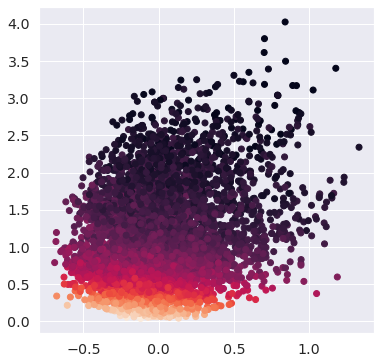

In [470]:
plt.figure(figsize=(6,6))
K = len(manifolds)
mask = np.eye(K, dtype='bool')
plt.scatter( (bias/np.sqrt(noise))[~mask],
            ( dist_norm_IT**2/np.sqrt(noise))[~mask], c=err_IT[~mask])

# V4

In [1156]:
compact_data = neural_data.multi_groupby(['category_name', 'object_name', 'image_id']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='V4')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)

In [1090]:
compact_data = compact_data[stim_to_cd[640:]]

In [1157]:
features_v4 = compact_data.values

manifolds_v4 = []
for ci in class_idxs:
    manifolds_v4.append(features_v4[ci])
manifolds_v4 = np.stack(manifolds_v4)

In [1158]:
# # Try z-scoring
# mu = manifolds_v4.mean((0,1))
# std = manifolds_v4.std((0,1))

# manifolds_v4 = (manifolds_v4 - mu) / std

In [1159]:
Rs_v4 = []
centers_v4 = []
Us_v4 = []
for manifold in manifolds_v4:
    centers_v4.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_v4.append(R)
    Us_v4.append(V)
Rs_v4 = np.stack(Rs_v4)
centers_v4 = np.stack(centers_v4)
Us_v4 = np.stack(Us_v4)

In [1160]:
Ds_v4 = np.sum(Rs_v4**2,axis=-1)**2 / np.sum(Rs_v4**4, axis=-1)

In [1161]:
print('V4 Dsvd: ' + str(Ds_v4 ))

V4 Dsvd: [ 8.907412  11.928525   8.232498   6.7768307  7.097783   9.158406
  8.5641575  7.6944575]


In [1073]:
err_v4, err_v4_std = compute_err(manifolds_v4,m)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


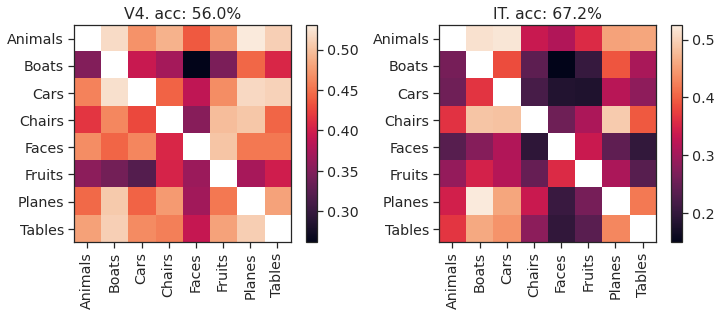

In [1074]:
plt.figure(figsize=(12,4))
with sns.axes_style('ticks'):
    plt.subplot(121)
    plt.imshow(err_v4)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    # plt.axis('off')
    plt.title('V4. acc: {:.1f}%'.format(100*(1-np.nanmean(err_v4))))
    
    plt.subplot(122)
    plt.imshow(err_IT)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    # plt.axis('off')
    plt.title('IT. acc: {:.1f}%'.format(100*(1-np.nanmean(err_IT))))

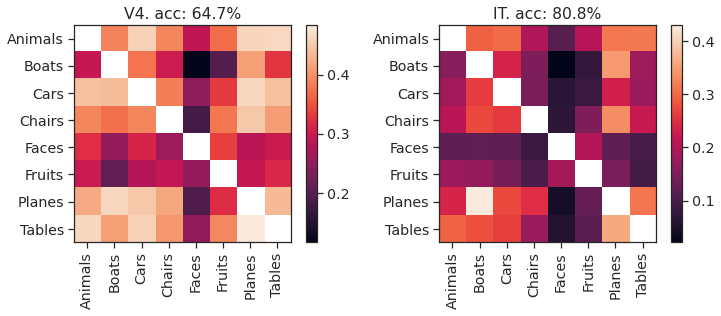

In [455]:
plt.figure(figsize=(12,4))
with sns.axes_style('ticks'):
    plt.subplot(121)
    plt.imshow(err_v4)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    # plt.axis('off')
    plt.title('V4. acc: {:.1f}%'.format(100*(1-np.nanmean(err_v4))))
    
    plt.subplot(122)
    plt.imshow(err_IT)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    # plt.axis('off')
    plt.title('IT. acc: {:.1f}%'.format(100*(1-np.nanmean(err_IT))))

In [1075]:
dist_norm_v4, Ds_v4, csa_v4, ss_v4, SNR_v4 = geometry(centers_v4,Rs_v4,Us_v4,m)

In [1076]:
Ds_v4

array([5.2430253, 8.163986 , 5.8866034, 4.7504606, 4.7811885, 6.544756 ,
       5.1978526, 5.1205797], dtype=float32)

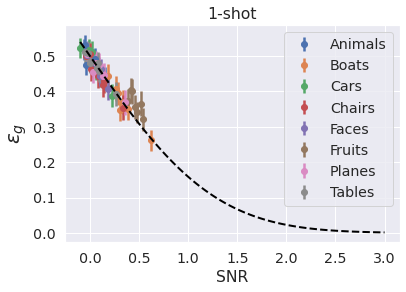

In [1079]:
x = np.linspace(-0.1,3,100)
for i in range(len(manifolds)):
#     plt.scatter(SNR[i], err_all[i], label=uniq_labels[i])
    plt.errorbar(SNR_v4[i], err_v4[i], yerr=err_v4_std[i]/np.sqrt(n_avg)*3,
                 label=uniq_labels[i], fmt='o')
plt.plot(x,H(x),linestyle='dashed',c='black', linewidth=2, zorder=99)
plt.legend();
plt.xlabel('SNR')
plt.ylabel(r'$\varepsilon_g$', fontsize=20)
plt.title(str(m)+'-shot');
# plt.savefig('5_shot.png')

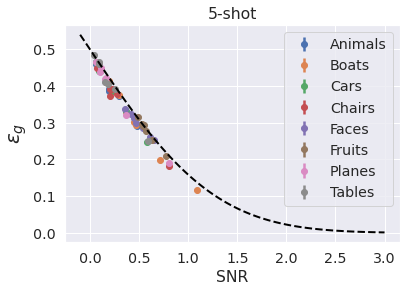

In [456]:
x = np.linspace(-0.1,3,100)
for i in range(len(manifolds)):
#     plt.scatter(SNR[i], err_all[i], label=uniq_labels[i])
    plt.errorbar(SNR_v4[i], err_v4[i], yerr=err_std[i]/np.sqrt(n_avg)*3, label=uniq_labels[i], fmt='o')
plt.plot(x,H(x),linestyle='dashed',c='black', linewidth=2, zorder=99)
plt.legend();
plt.xlabel('SNR')
plt.ylabel(r'$\varepsilon_g$', fontsize=20)
plt.title(str(m)+'-shot');
# plt.savefig('5_shot.png')

# Stimuli

In [315]:
stimulus_set = neural_data.attrs['stimulus_set']

In [651]:
image_path = stimulus_set.get_image(stimulus_set['image_id'][0])
print(image_path)

/home/bsorsch/.brainio/image_dicarlo_hvm-public/8a72e2bfdb8c267b57232bf96f069374d5b21832.png


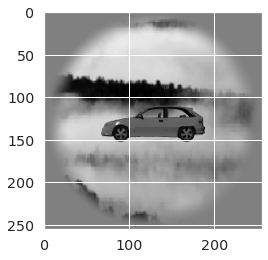

In [652]:
%matplotlib inline
from matplotlib import pyplot, image
img = image.imread(image_path)
pyplot.imshow(img)
pyplot.show()

In [653]:
imnames = stimulus_set['filename'].values

In [654]:
categories = stimulus_set['category_name'].values
uniq_cats = np.unique(categories)

cat_idxs = []
for cat in uniq_cats:
    cat_idxs.append(np.where(categories==cat)[0])

In [412]:
import os
imfiles = os.listdir('/home/bsorsch/.brainio/image_dicarlo_hvm-public/')
imfiles = [im for im in imfiles if '.png' in im]
imfiles = np.stack(imfiles)

In [413]:
stim_idxs = []
for imname in imnames:
    stim_idxs.append(np.where(imfiles==imname)[0][0])
stim_idxs = np.stack(stim_idxs)

# V1 and pixels

In [414]:
features_v1 = np.load('manifold/data/dicarlo_V1_manifolds.npy')

In [415]:
manifolds_v1 = []
for cat in cat_idxs:
    manifolds_v1.append(features_v1[stim_idxs[cat]])

In [416]:
Rs_v1 = []
centers_v1 = []
Us_v1 = []
for manifold in tqdm(manifolds_v1):
    centers_v1.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_v1.append(R)
    Us_v1.append(V)
Rs_v1 = np.stack(Rs_v1)
centers_v1 = np.stack(centers_v1)
Us_v1 = np.stack(Us_v1)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [417]:
dist_norm_v1, Ds_v1, csa_v1, SNR_v1 = geometry(centers_v1,Rs_v1,Us_v1,m)

In [457]:
err_v1 = compute_err(manifolds_v1,m)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


# Pixels

In [418]:
categories = stimulus_set['category_name'].values
uniq_cats = np.unique(categories)

cat_idxs = []
for cat in uniq_cats:
    cat_idxs.append(np.where(categories==cat)[0])

In [419]:
from PIL import Image
im = np.array(Image.open(image_path))

In [420]:
imnames_sort = []
for cat in cat_idxs:
    imnames_sort.append(imnames[cat])

In [573]:
np.save('manifold/data/majaj_2015_imnames.npy', imnames_sort)

In [421]:
imnames = stimulus_set['image_id'].values

idxs = np.random.choice(256*256*3, 2048, replace=False)
manifolds_im = []
for cat in tqdm(cat_idxs):
    for im in imnames[cat]:
        image_path = stimulus_set.get_image(im)
        manifolds_im.append(np.array(Image.open(image_path),dtype='float').flatten()[idxs])
manifolds_im = np.stack(manifolds_im).reshape(8,400,2048)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [422]:
Rs_im = []
centers_im = []
Us_im = []
for manifold in tqdm(manifolds_im):
    centers_im.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_im.append(R)
    Us_im.append(V)
Rs_im = np.stack(Rs_im)
centers_im = np.stack(centers_im)
Us_im = np.stack(Us_im)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [423]:
dist_norm_im, Ds_im, csa_im, SNR_im = geometry(centers_im,Rs_im,Us_im,m)

In [458]:
err_im = compute_err(manifolds_im,m)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [424]:
sns.set_style('darkgrid')

In [444]:
print(np.mean(Ds_v1)),
print(np.mean(Ds_v4)), 
print(np.mean(Ds_IT))

76.9266
6.247783
15.4367895


In [460]:
print(np.mean(err_v1[~mask])),
print(np.mean(err_v4[~mask])), 
print(np.mean(err_IT[~mask]))

0.4754204339963834
0.35338707052441226
0.19225967450271247


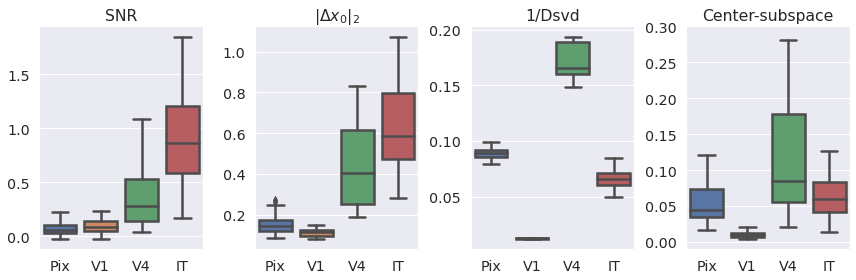

In [426]:
plt.figure(figsize=(12,4))

mask = np.eye(8,dtype='bool')

plt.subplot(141)
sns.boxplot(data=[SNR_im[~mask], SNR_v1[~mask],SNR_v4[~mask], SNR_IT[~mask]])
plt.title('SNR');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(142)
sns.boxplot(data=[dist_norm_im[~mask], dist_norm_v1[~mask],dist_norm_v4[~mask], dist_norm_IT[~mask]])
plt.title(r'$\|\Delta x_0\|_2$');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(143)
sns.boxplot(data=[1/Ds_im, 1/Ds_v1, 1/Ds_v4, 1/Ds_IT], fliersize=0)
plt.title('1/Dsvd')
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(144)
sns.boxplot(data=[css_im[~mask], css_v1[~mask], css_v4[~mask], css_IT[~mask]], fliersize=0)
plt.title('Center-subspace');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])
plt.ylim([-.01,0.3])
plt.tight_layout();

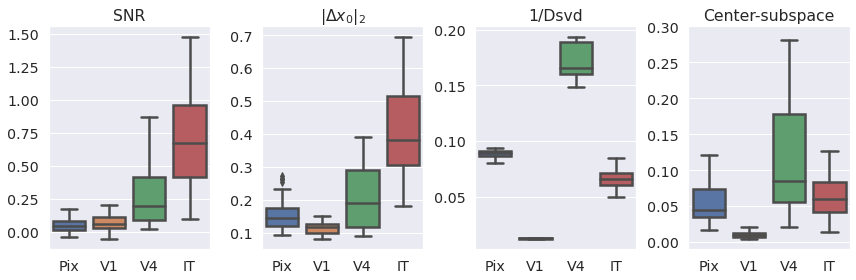

In [78]:
plt.figure(figsize=(12,4))

mask = np.eye(8,dtype='bool')

plt.subplot(141)
sns.boxplot(data=[SNR_im[~mask], SNR_v1[~mask],SNR_v4[~mask], SNR_IT[~mask]])
plt.title('SNR');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(142)
sns.boxplot(data=[dist_norm_im[~mask], dist_norm_v1[~mask],dist_norm_v4[~mask], dist_norm_IT[~mask]])
plt.title(r'$\|\Delta x_0\|_2$');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(143)
sns.boxplot(data=[1/Ds_im, 1/Ds_v1, 1/Ds_v4, 1/Ds_IT], fliersize=0)
plt.title('1/Dsvd')
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])

plt.subplot(144)
sns.boxplot(data=[css_im[~mask], css_v1[~mask], css_v4[~mask], css_IT[~mask]], fliersize=0)
plt.title('Center-subspace');
plt.xticks([0,1,2,3],['Pix','V1','V4','IT'])
plt.ylim([-.01,0.3])
plt.tight_layout();

# Semantic

In [471]:
root = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'
names = np.load(root + 'names.npy')
root_paths = np.load(root + 'root_paths.npy',allow_pickle=True)

In [473]:
root_paths_21k = np.load('../manifold_old/data/21k_root_paths.npy',allow_pickle=True)

In [474]:
# Wordnet tools
import pandas as pd
wordnet = np.load('../manifold_old/data/wordnet_hierarchy.npy', allow_pickle=True)
synset_wnids = pd.read_csv('../manifold_old/data/words.txt', sep='\t')
synset_wnids = synset_wnids.to_numpy()

def class_from_wnid(wnid):
    return  synset_wnids[np.where(synset_wnids==wnid)[0], 1][0]
# get_class_name(wnid)

def wnid_from_class(classname):
    return  synset_wnids[np.where(synset_wnids==classname)[0], 0][0]

def get_parent(cls):
    # Try to find parent
    try:
        wnid = wnid_from_class(cls)
        parent_loc = np.where(np.where(wordnet==wnid)[1]==1)
        parent_idx = np.where(wordnet==wnid)[0][parent_loc]
        parent_wnid = wordnet[parent_idx][0,0]
        parent_cls = class_from_wnid(parent_wnid)
        return parent_cls
    # If already at top of tree, return None
    except:
        return None
    

In [489]:
get_parent('dog')

'chap, fellow, feller, fella, lad, gent, blighter, cuss, bloke'

In [492]:
uniq_labels

array(['bear', 'cow', 'dog', 'elephant', 'gorilla', 'hedgehog', 'lioness',
       'turtle', 'ship0', 'ship1', 'ship2', 'ship3', 'ship4', 'ship5',
       'ship6', 'ship7', 'car_alfa', 'car_astra', 'car_beetle', 'car_bmw',
       'car_bora', 'car_celica', 'car_clio', 'car_z3', 'chair0', 'chair1',
       'chair2', 'chair3', 'chair4', 'chair5', 'chair6', 'chair7',
       'face0', 'face1', 'face2', 'face3', 'face4', 'face5', 'face6',
       'face7', 'apple', 'apricot', 'peach', 'pear', 'raspberry',
       'strawberry', 'walnut', 'watermelon', 'airplane0', 'airplane1',
       'airplane2', 'airplane3', 'airplane4', 'airplane5', 'airplane6',
       'airplane7', 'table0', 'table1', 'table2', 'table3', 'table4',
       'table5', 'table6', 'table7'], dtype=object)

In [515]:
i = 0
rp = []
cls = 'porcupine, hedgehog'
rp.append(cls)
parent = get_parent(cls)
while parent:
    rp.append(parent)
    cls = parent
    parent = get_parent(cls)
print(rp)

['porcupine, hedgehog', 'rodent, gnawer', 'placental, placental mammal, eutherian, eutherian mammal', 'mammal, mammalian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']


In [516]:
# Root paths
bear_rp = ['bear', 'carnivore', 'predator, predatory animal', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
cow_rp = ['cow', 'placental, placental mammal, eutherian, eutherian mammal', 'mammal, mammalian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
dog_rp = ['dog, domestic dog, Canis familiaris', 'canine, canid', 'carnivore', 'predator, predatory animal', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
elephant_rp = ['elephant', 'pachyderm', 'placental, placental mammal, eutherian, eutherian mammal', 'mammal, mammalian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
gorilla_rp = ['gorilla, Gorilla gorilla', 'great ape, pongid', 'anthropoid ape', 'ape', 'primate', 'placental, placental mammal, eutherian, eutherian mammal', 'mammal, mammalian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
hedgehog_rp = ['porcupine, hedgehog', 'rodent, gnawer', 'placental, placental mammal, eutherian, eutherian mammal', 'mammal, mammalian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
lioness_rp = ['lioness', 'lion, king of beasts, Panthera leo', 'big cat, cat', 'feline, felid', 'carnivore', 'predator, predatory animal', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
turtle_rp = ['turtle', 'chelonian, chelonian reptile', 'anapsid, anapsid reptile', 'reptile, reptilian', 'vertebrate, craniate', 'chordate', 'animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']

apple_rp = ['apple', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
apricot_rp = ['apricot', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
peach_rp = ['peach', 'drupe, stone fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
pear_rp = ['pear', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
raspberry_rp = ['raspberry', 'berry', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
strawberry_rp = ['strawberry', 'berry', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
walnut_rp = ['walnut', 'edible nut', 'nut', 'seed', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
watermelon_rp = ['watermelon', 'melon', 'edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']

In [510]:
# old Root paths
animal_rp = ['animal, animate being, beast, brute, creature, fauna', 'organism, being', 'living thing, animate thing', 'whole, unit', 'object, physical object', 'physical entity']
boat_rp = ['boat', 'vessel, watercraft', 'craft', 'vehicle', 'conveyance, transport', 'instrumentality, instrumentation', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity']
car_rp = ['car, auto, automobile, machine, motorcar', 'motor vehicle, automotive vehicle', 'self-propelled vehicle', 'wheeled vehicle', 'vehicle', 'conveyance, transport', 'instrumentality, instrumentation', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity']
chair_rp = ['chair', 'seat', 'furniture, piece of furniture, article of furniture', 'furnishing', 'instrumentality, instrumentation', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity']
face_rp = ['face, human face', 'external body part', 'body part', 'part, piece', 'thing', 'physical entity']
fruit_rp = ['edible fruit', 'fruit', 'reproductive structure', 'plant organ', 'plant part, plant structure', 'natural object', 'whole, unit', 'object, physical object', 'physical entity']
plane_rp = ['aircraft', 'craft', 'vehicle', 'conveyance, transport', 'instrumentality, instrumentation', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity']
table_rp = ['table', 'furniture, piece of furniture, article of furniture', 'furnishing', 'instrumentality, instrumentation', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity']

In [517]:
majaj_rps = []

majaj_rps.append(bear_rp)
majaj_rps.append(cow_rp)
majaj_rps.append(dog_rp)
majaj_rps.append(elephant_rp)
majaj_rps.append(gorilla_rp)
majaj_rps.append(hedgehog_rp)
majaj_rps.append(lioness_rp)
majaj_rps.append(turtle_rp)

for i in range(8):
    majaj_rps.append(boat_rp)
for i in range(8):
    majaj_rps.append(car_rp)
for i in range(8):
    majaj_rps.append(chair_rp)
for i in range(8):
    majaj_rps.append(face_rp)
    
majaj_rps.append(apricot_rp)
majaj_rps.append(apple_rp)
majaj_rps.append(peach_rp)
majaj_rps.append(pear_rp)
majaj_rps.append(raspberry_rp)
majaj_rps.append(strawberry_rp)
majaj_rps.append(walnut_rp)
majaj_rps.append(watermelon_rp)

for i in range(8):
    majaj_rps.append(plane_rp)
for i in range(8):
    majaj_rps.append(table_rp)

In [75]:
majaj_rps = [animal_rp,boat_rp,car_rp,
             chair_rp,face_rp,fruit_rp,
             plane_rp,table_rp]

In [518]:
print('Finding tree dists.')
tree_dists = []
for i in tqdm(range(len(majaj_rps))):
    for j in range(len(majaj_rps)):
        for a, catg in enumerate(majaj_rps[i]):
            b = np.where(np.array(majaj_rps[j])==catg)[0]
            if b:
                break
        if b:
            tree_dists.append(int(a+b))
        else:
            if len(root_paths[i]) + len(root_paths[j]) > 2:
                tree_dists.append(len(root_paths[i]) + len(root_paths[j]))
            else:
                tree_dists.append(17)

tree_dists = np.stack(tree_dists).reshape(len(majaj_rps), len(majaj_rps))

Finding tree dists.


/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys


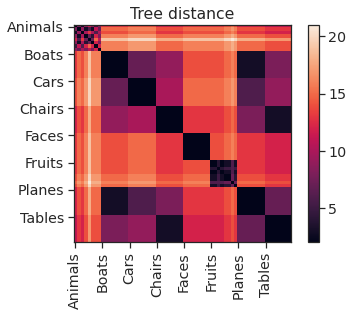

In [520]:
with sns.axes_style('ticks'):
    plt.imshow(tree_dists)
    plt.xticks(np.arange(len(uniq_classes))*8,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8,list(uniq_classes))
    plt.colorbar()
    plt.title('Tree distance')
    # plt.axis('off')

0.8075334538878842


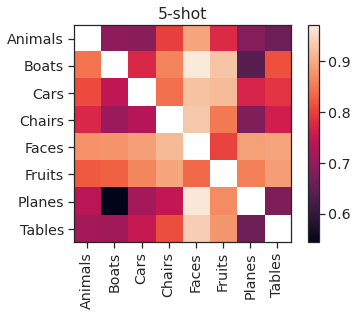

In [61]:
with sns.axes_style('ticks'):
    plt.imshow(1-err_IT)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    plt.title(str(m) +'-shot')
    # plt.axis('off')
print(1-np.nanmean(err_IT))

In [63]:
uniq_labels

array(['Animals', 'Boats', 'Cars', 'Chairs', 'Faces', 'Fruits', 'Planes',
       'Tables'], dtype=object)

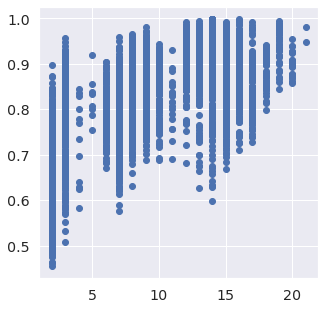

In [521]:
plt.figure(figsize=(5,5))
plt.scatter(tree_dists[~mask], 1-err_IT[~mask])

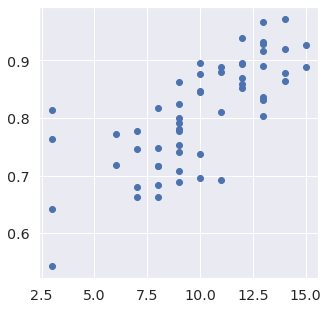

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(tree_dists[~mask], 1-err_IT[~mask])

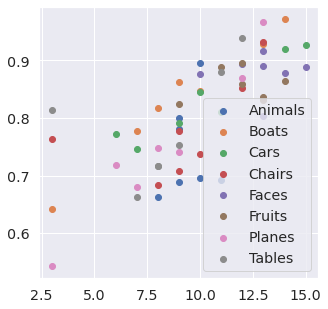

In [79]:
plt.figure(figsize=(5,5))
mask = np.eye(8,dtype='bool')
for i in range(8):
    plt.scatter(tree_dists[i], 1-err_IT[i], label=uniq_labels[i])
plt.legend()

In [523]:
K

64

In [569]:
cond_dist = []
cd_mean = []
cd_std = []
counts = []
tds = np.sort(np.unique(tree_dists))
mask = np.eye(K,dtype='bool')  # remove diagonal entries
for i in tds:
    idxs = np.where(tree_dists[~mask]==i)
    cd_mean.append(np.mean(err_IT[~mask][idxs]))
    cd_std.append(np.std(err_IT[~mask][idxs]))
    counts.append(len(idxs[0]))
cd_mean = np.stack(cd_mean)
cd_std = np.stack(cd_std)

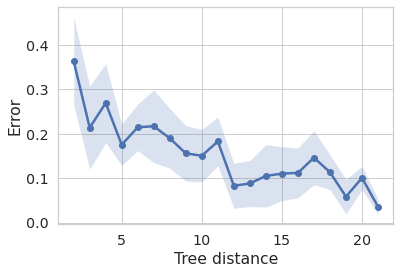

In [570]:
with sns.axes_style('whitegrid'):
    plt.plot(tds,cd_mean, 'o-')
    plt.fill_between(tds,
                     cd_mean+cd_std,cd_mean-cd_std,
                    alpha=0.2)
    plt.ylabel('Error')
    plt.xlabel('Tree distance')

In [572]:
cond_dist = []
cd_mean = []
cd_std = []
counts = []
tds = np.sort(np.unique(tree_dists))
mask = np.eye(K,dtype='bool')  # remove diagonal entries
for i in tds:
    idxs = np.where(tree_dists[~mask]==i)
    cond_dist.append(dist_norm_IT[~mask][idxs])
    cd_mean.append(np.mean(dist_norm_IT[~mask][idxs]))
    cd_std.append(np.std(dist_norm_IT[~mask][idxs]))
    counts.append(len(idxs[0]))
cd_mean = np.stack(cd_mean)
cd_std = np.stack(cd_std)

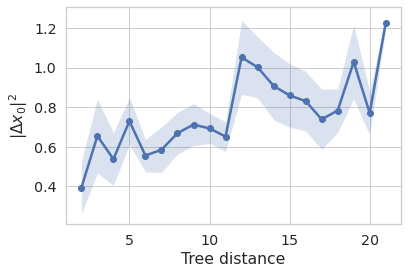

In [573]:
with sns.axes_style('whitegrid'):
    plt.plot(tds,cd_mean, 'o-')
    plt.fill_between(tds,
                     cd_mean+cd_std,cd_mean-cd_std,
                    alpha=0.2)
    plt.ylabel(r'$\|\Delta x_0\|^2$')
    plt.xlabel('Tree distance')

In [574]:
bias = np.abs((Rs**2).sum(-1)/(Rs**2).sum(-1)[:,None] - 1)

In [575]:
cond_dist = []
cb_mean = []
cb_std = []
counts = []
tds = np.sort(np.unique(tree_dists))
mask = np.eye(K,dtype='bool')  # remove diagonal entries
for i in tds:
    idxs = np.where(tree_dists[~mask]==i)
    cb_mean.append(np.mean(bias[~mask][idxs]))
    cb_std.append(np.std(bias[~mask][idxs]))
    counts.append(len(idxs[0]))
cb_mean = np.stack(cb_mean)
cb_std = np.stack(cb_std)

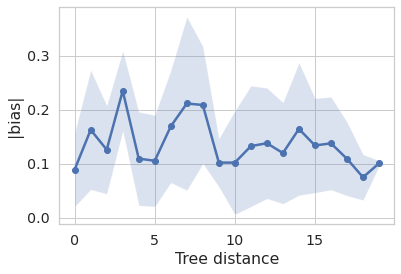

In [576]:
with sns.axes_style('whitegrid'):
    plt.plot(np.arange(len(cb_mean)),cb_mean, 'o-')
    plt.fill_between(np.arange(len(cb_mean)),
                     cb_mean+cb_std,cb_mean-cb_std,
                    alpha=0.2)
    plt.ylabel('|bias|')
    plt.xlabel('Tree distance')

In [577]:
cond_cs = []
cond_cs_mean = []
cond_cs_std = []
counts = []
tds = np.sort(np.unique(tree_dists))
mask = np.eye(K,dtype='bool')  # remove diagonal entries
for i in tds:
    idxs = np.where(tree_dists[~mask]==i)
    cond_cs.append(csa_IT[~mask][idxs])
    cond_cs_mean.append(np.mean(csa_IT[~mask][idxs]))
    cond_cs_std.append(np.std(csa_IT[~mask][idxs]))
    counts.append(len(idxs[0]))
cond_cs_mean = np.stack(cond_cs_mean)
cond_cs_std = np.stack(cond_cs_std)

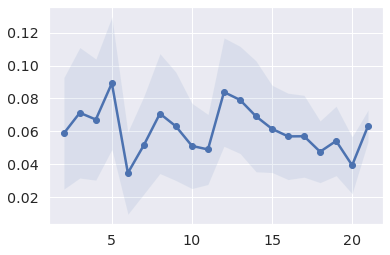

In [578]:
plt.plot(tds, cond_cs_mean, 'o-')
plt.fill_between(tds,
                 cond_cs_mean+cond_cs_std,cond_cs_mean-cond_cs_std,
                alpha=0.1)
# plt.yscale('log')

In [579]:
cond_ss = []
cond_ss_mean = []
cond_ss_std = []
counts = []
tds = np.sort(np.unique(tree_dists))
mask = np.eye(K,dtype='bool')  # remove diagonal entries
for i in tds:
    idxs = np.where(tree_dists[~mask]==i)
    cond_ss.append(ss_IT[~mask][idxs])
    cond_ss_mean.append(np.mean(ss_IT[~mask][idxs]))
    cond_ss_std.append(np.std(ss_IT[~mask][idxs]))
    counts.append(len(idxs[0]))
cond_ss_mean = np.stack(cond_ss_mean)
cond_ss_std = np.stack(cond_ss_std)

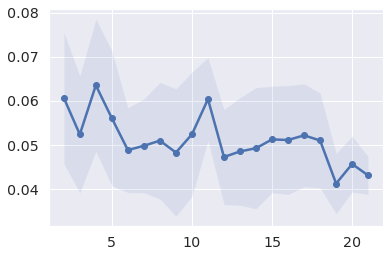

In [580]:
plt.plot(tds,cond_ss_mean, 'o-')
plt.fill_between(tds,
                 cond_ss_mean+cond_ss_std,cond_ss_mean-cond_ss_std,
                alpha=0.1)
# plt.yscale('log')

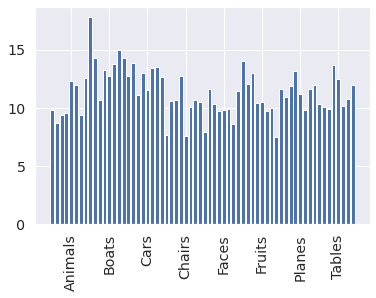

In [538]:
plt.bar(np.arange(len(Ds_IT)),Ds_IT)
plt.xticks(np.arange(len(uniq_classes))*8+4,list(uniq_classes),rotation=90);

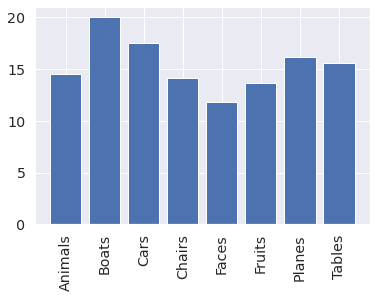

In [126]:
plt.bar(np.arange(len(Ds_IT)),Ds_IT)
plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90);

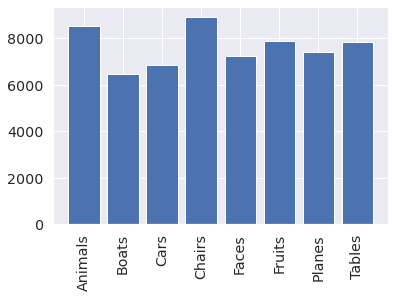

In [129]:
plt.bar(np.arange(len(Ds_IT)),(Rs**2).sum(-1))
plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90);

(array([ 4.,  8.,  8.,  7., 10.,  4.,  8.,  5.,  0.,  2.]),
 array([0.0142264 , 0.0255404 , 0.0368544 , 0.0481684 , 0.0594824 ,
        0.0707964 , 0.0821104 , 0.09342441, 0.10473841, 0.11605241,
        0.12736641]),
 <BarContainer object of 10 artists>)

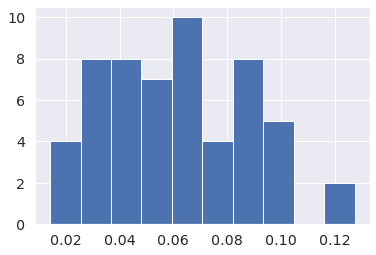

In [130]:
plt.hist(csa_IT[~mask])

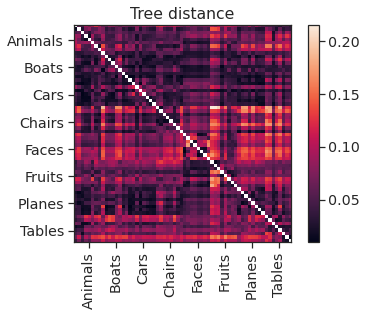

In [540]:
with sns.axes_style('ticks'):
    plt.imshow(csa_IT)
    plt.xticks(np.arange(len(uniq_classes))*8+4,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8+4,list(uniq_classes))
    plt.colorbar()
    plt.title('Tree distance')
    # plt.axis('off')

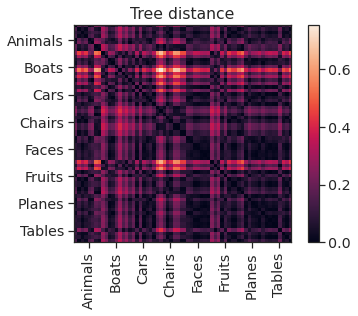

In [541]:
with sns.axes_style('ticks'):
    plt.imshow(bias)
    plt.xticks(np.arange(len(uniq_classes))*8+4,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8+4,list(uniq_classes))
    plt.colorbar()
    plt.title('Tree distance')
    # plt.axis('off')

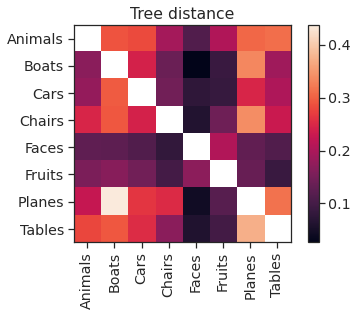

In [167]:
with sns.axes_style('ticks'):
    plt.imshow(err_IT)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    plt.title('Tree distance')
    # plt.axis('off')

In [168]:
i1,i2 = np.unravel_index(np.argsort((err_IT - err_IT.T).ravel()),(8,8))

In [169]:
err_IT[i1,i2] - err_IT[i2,i1]

array([-0.1543038 , -0.11962025, -0.1035443 , -0.10237975, -0.102     ,
       -0.09994937, -0.09592405, -0.08665823, -0.08478481, -0.07949367,
       -0.07718987, -0.06225316, -0.06010127, -0.05726582, -0.05481013,
       -0.05189873, -0.05179747, -0.05040506, -0.04964557, -0.04306329,
       -0.03475949, -0.03440506, -0.03410127, -0.01825316, -0.0176962 ,
       -0.01594937, -0.0144557 , -0.01      ,  0.01      ,  0.0144557 ,
        0.01594937,  0.0176962 ,  0.01825316,  0.03410127,  0.03440506,
        0.03475949,  0.04306329,  0.04964557,  0.05040506,  0.05179747,
        0.05189873,  0.05481013,  0.05726582,  0.06010127,  0.06225316,
        0.07718987,  0.07949367,  0.08478481,  0.08665823,  0.09592405,
        0.09994937,  0.102     ,  0.10237975,  0.1035443 ,  0.11962025,
        0.1543038 ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan])

In [174]:
for i in range(5):
    print(uniq_labels[i1[i]] + ' vs ' + uniq_labels[i2[i]])

Boats vs Chairs
Boats vs Animals
Boats vs Tables
Boats vs Planes
Cars vs Animals


In [175]:
err_IT[i1[0],i2[0]]

0.13908860759493671

In [176]:
err_IT[i2[0],i1[0]]

0.2933924050632911

# Classification

In [619]:
from sklearn.svm import SVC
svm = SVC(C=5e4, kernel='linear')

In [620]:
ntrain = int(0.8*400)
train_idxs, test_idxs = np.split(np.random.permutation(400), (ntrain,))
Xtrain = manifolds[:,train_idxs].reshape(-1,168)
Xtest = manifolds[:,test_idxs].reshape(-1,168)
ytrain = np.repeat(np.arange(8),ntrain)
ytest = np.repeat(np.arange(8),400-ntrain)

## Pairwise

In [621]:
ntrain = int(0.8*400)
n_avg = 10
ytrain = np.repeat(np.arange(2),ntrain)
ytest = np.repeat(np.arange(2),400-ntrain)

K = 8
pair_errs = []
for _ in tqdm(range(n_avg)):
    train_idxs, test_idxs = np.split(np.random.permutation(400), (ntrain,))
    for a in range(K):
        for b in range(K):
            if a!=b:
                Xtrain = np.vstack([manifolds[a,train_idxs],manifolds[b,train_idxs]])
                Xtest = np.vstack([manifolds[a,test_idxs],manifolds[b,test_idxs]])
                svm.fit(Xtrain,ytrain)
                yhat = svm.predict(Xtest)
                pair_errs.append(np.mean(yhat!=ytest))
            else:
                pair_errs.append(np.nan)
pair_errs = np.stack(pair_errs).reshape(n_avg,K,K)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


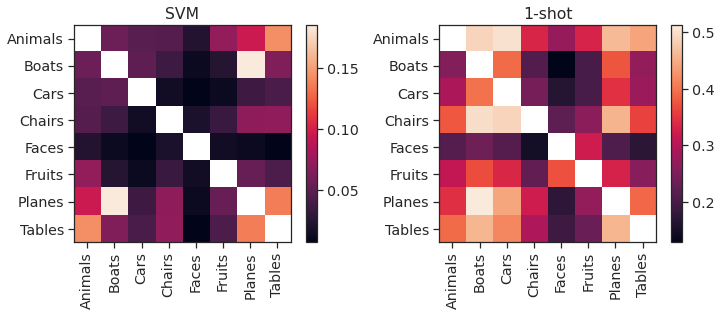

In [622]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(pair_errs.mean(0))
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    plt.title('SVM')
    
    plt.subplot(122)
    plt.imshow(err_IT)
    plt.xticks(range(len(uniq_labels)),list(uniq_labels),rotation=90)
    plt.yticks(range(len(uniq_labels)),list(uniq_labels))
    plt.colorbar()
    plt.title(str(m) +'-shot')

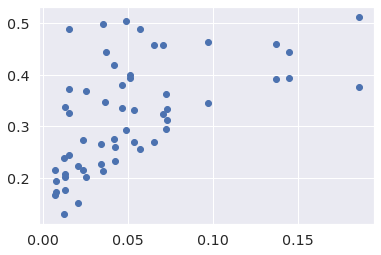

In [623]:
plt.scatter(pair_errs.mean(0)[~mask], err_IT[~mask])

# Prototype vs exemplar

In [542]:
# Compute error
m = 1
n_avg = 1000

def compute_err(manifolds,m):
    err_all = np.zeros((len(manifolds),len(manifolds)))
    err_std = np.zeros((len(manifolds),len(manifolds)))
    for a in tqdm(range(len(manifolds)),leave=False):
        Xa = manifolds[a]
        for b in range(len(manifolds)):
            Xb = manifolds[b]

            errs = []
            for _ in range(n_avg):
                perma = np.random.permutation(len(Xa))
                permb = np.random.permutation(len(Xb))

                xa,ya = np.split(Xa[perma],(m,))
                xb,yb = np.split(Xb[permb],(m,))
                w = (xa-xb).mean(0)
                mu = (xa+xb).mean(0)/2

                h = ya@w - w@mu
                err = (h<0).mean()
                errs.append(err)
            err_all[a,b] = np.mean(errs)
            err_std[a,b] = np.std(errs)
    np.fill_diagonal(err_all,np.nan)
    
    return err_all, err_std

In [272]:
ms = np.arange(1,10)
errs = []
for m in ms:
    err,_ = compute_err(manifolds,m)
    errs.append(err)
errs = np.stack(errs)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [543]:
from sklearn.svm import LinearSVC, SVC
# svm = LinearSVC(C=1e10,intercept_scaling=1e10)
svm = SVC(C=1000, kernel='linear',)

In [544]:
from sklearn.neighbors import KNeighborsClassifier
NN = KNeighborsClassifier(n_neighbors=1,)

In [547]:
P = 50
ms = np.arange(1,20)
n_avg = 10
svm_errs = []
NN_errs = []
proto_errs = []
for m in tqdm(ms):
    for _ in range(n_avg):
        for a in range(K):
            for b in range(K):
                if a!=b:
                    tr_idxs_a,ts_idxs_a = np.split(np.random.permutation(P), (m,))
                    tr_idxs_b,ts_idxs_b = np.split(np.random.permutation(P), (m,))
                    
                    # Prototype
                    xa = manifolds[a,tr_idxs_a]
                    xb = manifolds[b,tr_idxs_b]
                    xa_test = manifolds[a,ts_idxs_a]
                    w = (xa-xb).mean(0)
                    mu = (xa+xb).mean(0)/2
                    h = xa_test@w - w@mu
                    err = (h<0).mean()
                    proto_errs.append(err)

                    # SVM
                    Xtrain = np.vstack([xa,xb])
                    ytrain = np.concatenate([np.ones(m), -np.ones(m)])                    
                    svm.fit(Xtrain,ytrain)
                    svm_errs.append((svm.predict(manifolds[a,ts_idxs_a])!=1).mean())
                    
                    #NN
                    NN.fit(Xtrain,ytrain)
                    NN_errs.append((NN.predict(manifolds[a,ts_idxs_a])!=1).mean())
                else:
                    svm_errs.append(np.nan)
                    NN_errs.append(np.nan)
                    proto_errs.append(np.nan)
svm_errs = np.stack(svm_errs).reshape(len(ms),n_avg, K, K)
NN_errs = np.stack(NN_errs).reshape(len(ms),n_avg, K, K)
proto_errs = np.stack(proto_errs).reshape(len(ms),n_avg, K, K)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


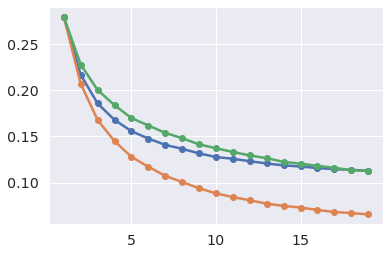

In [548]:
plt.plot(ms, proto_errs[:,:,~mask].mean((1,2)), 'o-')
plt.plot(ms, svm_errs[:,:,~mask].mean((1,2)), 'o-')
plt.plot(ms, NN_errs[:,:,~mask].mean((1,2)), 'o-')
# plt.yscale('log')

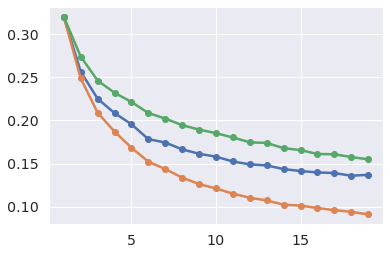

In [330]:
plt.plot(ms, proto_errs[:,:,~mask].mean((1,2)), 'o-')
plt.plot(ms, svm_errs[:,:,~mask].mean((1,2)), 'o-')
plt.plot(ms, NN_errs[:,:,~mask].mean((1,2)), 'o-')
# plt.yscale('log')

## Theory for svm

In [553]:
m = 5
ntrain = int(0.8*P)

ytrain = np.repeat(np.arange(2),ntrain)
ytest = np.repeat(np.arange(2),P-ntrain)

K = 64
n_avg = 10
pair_errs = []
for _ in tqdm(range(n_avg)):
    train_idxs, test_idxs = np.split(np.random.permutation(P), (ntrain,))
    for a in range(K):
        for b in range(K):
            if a!=b:
                Xtrain = np.vstack([manifolds[a,train_idxs],manifolds[b,train_idxs]])
                Xtest = np.vstack([manifolds[a,test_idxs],manifolds[b,test_idxs]])
                svm.fit(Xtrain,ytrain)
                yhat = svm.predict(Xtest)
                pair_errs.append(np.mean(yhat!=ytest))
            else:
                pair_errs.append(np.nan)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [554]:
pair_errs = np.stack(pair_errs).reshape(n_avg,K,K).mean(0)

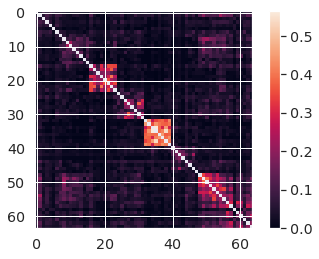

In [555]:
plt.imshow(pair_errs)
plt.colorbar();

In [556]:
1-np.mean(pair_errs[~mask])

0.9479823908730158

In [560]:
P = 50
m = 5
n_avg = 50
svm_errs = []
NN_errs = []
proto_errs = []
for _ in tqdm(range(n_avg)):
    for a in range(K):
        for b in range(K):
            if a!=b:
                tr_idxs_a,ts_idxs_a = np.split(np.random.permutation(P), (m,))
                tr_idxs_b,ts_idxs_b = np.split(np.random.permutation(P), (m,))

#                 # Prototype
                xa = manifolds[a,tr_idxs_a]
                xb = manifolds[b,tr_idxs_b]
#                 xa_test = manifolds[a,ts_idxs_a]
#                 w = (xa-xb).mean(0)
#                 mu = (xa+xb).mean(0)/2
#                 h = xa_test@w - w@mu
#                 err = (h<0).mean()
#                 proto_errs.append(err)

                # SVM
                Xtrain = np.vstack([xa,xb])
                ytrain = np.concatenate([np.ones(m), -np.ones(m)])                    
                svm.fit(Xtrain,ytrain)
                svm_errs.append((svm.predict(manifolds[a,ts_idxs_a])!=1).mean())
            else:
                svm_errs.append(np.nan)
                NN_errs.append(np.nan)
                proto_errs.append(np.nan)
svm_errs = np.stack(svm_errs).reshape(n_avg, K, K)
# proto_errs = np.stack(proto_errs).reshape(n_avg, K, K)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [561]:
svm_mean = np.stack(svm_errs).reshape(n_avg, K, K).mean(0)
svm_std = np.stack(svm_errs).reshape(n_avg, K, K).std(0)

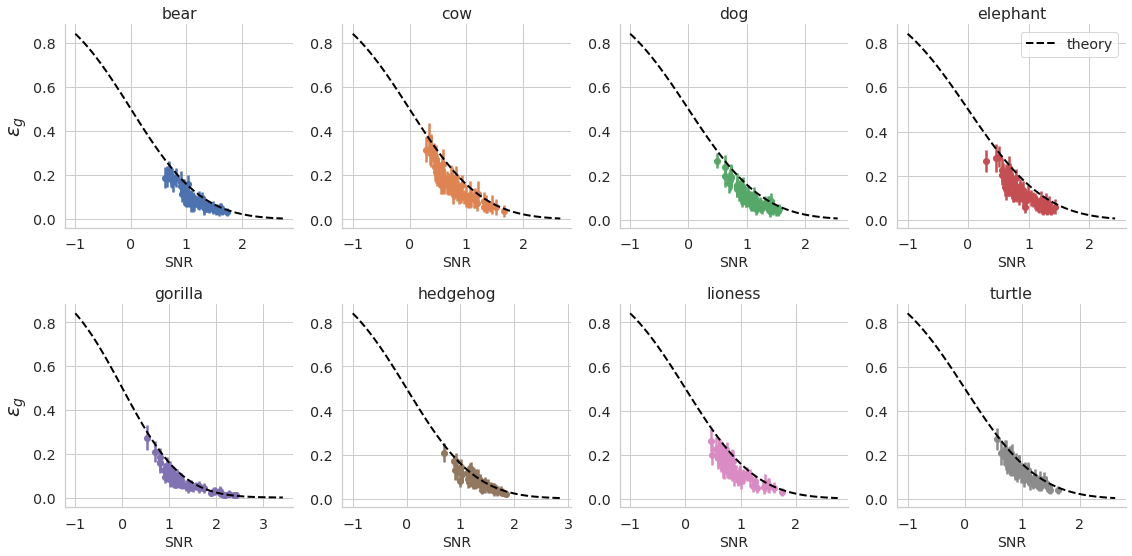

In [564]:
n_plots = 8
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.errorbar(SNR_IT[i], svm_mean[i],
                 yerr=svm_std[i]/np.sqrt(n_avg)*3, fmt='o', c='C' + str(c%10))
        plt.title(uniq_labels[i])
#         plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR_IT[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory', zorder=99)

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.tight_layout()

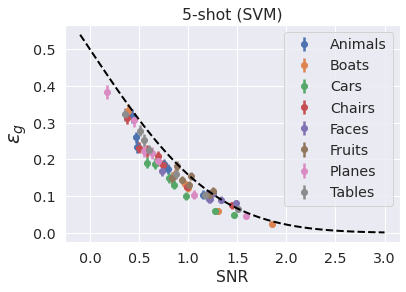

In [398]:
x = np.linspace(-0.1,3,100)
for i in range(len(manifolds)):
#     plt.scatter(SNR[i], err_all[i], label=uniq_labels[i])
    plt.errorbar(SNR_IT[i], svm_mean[i],
                 yerr=svm_std[i]/np.sqrt(n_avg)*3, label=uniq_labels[i], fmt='o')
plt.plot(x,H(x),linestyle='dashed',c='black', linewidth=2, zorder=99)
plt.legend();
plt.xlabel('SNR')
plt.ylabel(r'$\varepsilon_g$', fontsize=20)
plt.title(str(m)+'-shot (SVM)');
# plt.savefig('5_shot.png')

# ResNet

In [1522]:
manifolds_resnet = np.load('data/dicarlo_shallow_resnet_manifolds.npy')
manifolds_resnet = manifolds_resnet.reshape(3200,100352)[medvar_idxs].reshape(K,-1,100352)

In [1374]:
# # Try z-scoring
# mu = manifolds_resnet.mean((0,1))
# std = manifolds_resnet.std((0,1))

# manifolds_resnet = (manifolds_resnet - mu) / std

In [1429]:
Rs_rn = []
centers_rn = []
Us_rn = []
for manifold in manifolds_resnet:
    centers_rn.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_rn.append(R)
    Us_rn.append(V)
Rs_rn = np.stack(Rs_rn)
centers_rn = np.stack(centers_rn)
Us_rn = np.stack(Us_rn)

In [1430]:
m = 5
dist_norm_rn, Ds_rn, csa_rn, ss_rn, SNR_rn = geometry(centers_rn,Rs_rn,Us_rn,m)

In [1152]:
err_rn, err_std_rn = compute_err(manifolds_resnet,m)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.8353799922052154


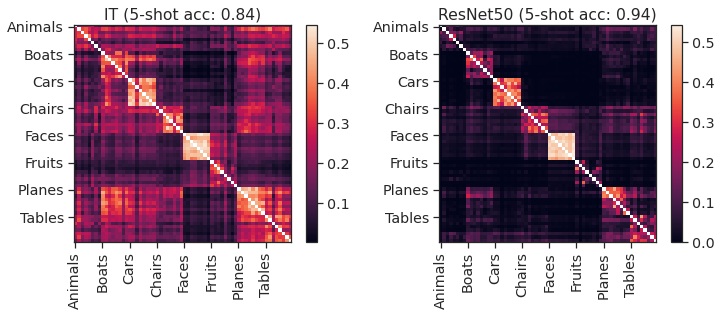

In [1153]:
plt.figure(figsize=(12,4))
with sns.axes_style('ticks'):
    plt.subplot(121)
    plt.imshow(err_IT)
    plt.xticks(np.arange(len(uniq_classes))*8,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8,list(uniq_classes))
    plt.colorbar()
    plt.title('IT (5-shot acc: {:.2f})'.format(1-np.nanmean(err_IT)))
    
    plt.subplot(122)
    plt.imshow(err_rn)
    plt.xticks(np.arange(len(uniq_classes))*8,list(uniq_classes),rotation=90)
    plt.yticks(np.arange(len(uniq_classes))*8,list(uniq_classes))
    plt.colorbar()
    plt.title('ResNet50 (5-shot acc: {:.2f})'.format(1-np.nanmean(err_rn)))
print(1-np.nanmean(err_IT))

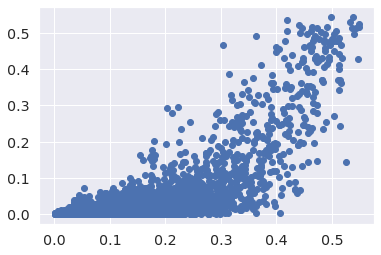

In [357]:
plt.scatter(err_IT[~mask], err_rn[~mask])

In [1431]:
bias_rn = (Rs_rn**2).sum(-1)[:,None] / (Rs_rn**2).sum(-1) - 1
bias_IT = (Rs**2).sum(-1)[:,None] / (Rs**2).sum(-1) - 1

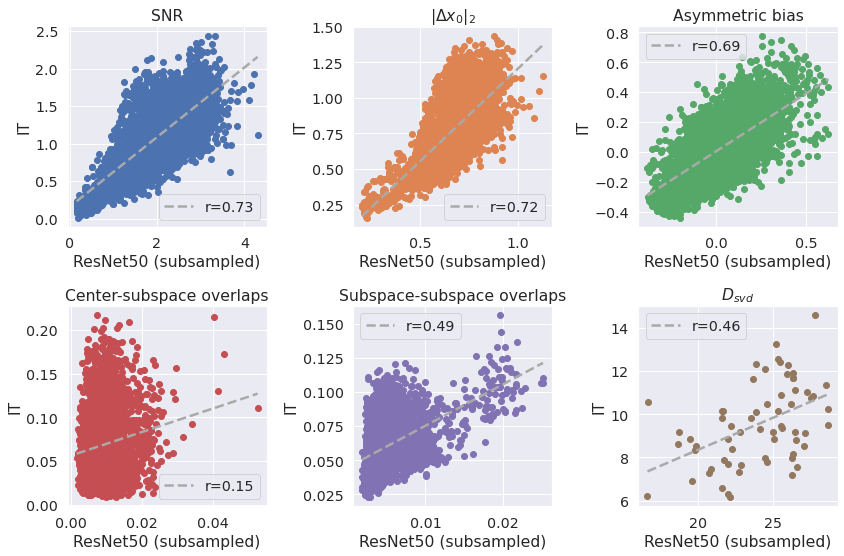

In [1432]:
plt.figure(figsize=(12,8))

plt.subplot(231)
x = SNR_rn[~mask]
y = SNR_IT[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title('SNR')

plt.subplot(232)
x = dist_norm_rn[~mask]
y = dist_norm_IT[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y, color='C1')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title('$\|\Delta x_0\|_2$')

plt.subplot(233)
x = bias_rn[~mask]
y = bias_IT[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C2')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title('Asymmetric bias')

plt.subplot(234)
x = csa_rn[~mask]
y = csa_IT[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C3')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title('Center-subspace overlaps')

plt.subplot(235)
x = ss_rn[~mask]
y = ss_IT[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C4')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title('Subspace-subspace overlaps')
plt.tight_layout()

plt.subplot(236)
x = Ds_rn
y = Ds_IT
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title(r'$D_{svd}$')
plt.tight_layout()

In [1528]:
manifolds_resnet.shape

(64, 40, 100352)

In [1529]:
O = np.random.randn(100352,168) / np.sqrt(168)

In [1530]:
r_SNR = []
r_dist = []
r_bias = []
r_ss = []
r_cs = []
r_D = []
p_SNR = []
p_dist = []
p_bias = []
p_ss = []
p_cs = []
p_D = []
m_D = []
b_D = []
m_SNR = []
b_SNR = []
m_dist = []
b_dist = []
m_bias = []
b_bias = []
m_cs = []
b_cs = []
m_ss = []
b_ss = []
Ds_rn_all = []
SNR_rn_all = []
dist_rn_all = []
bias_rn_all = []
cs_rn_all = []
ss_rn_all = []

for _ in tqdm(range(50)):
#     idxs = np.random.choice(np.arange(2048),168)
#     manifolds_small = manifolds_resnet[:,:,idxs]

    O = np.random.randn(100352,168) / np.sqrt(168)
    manifolds_small = manifolds_resnet@O

    Rs_rn = []
    centers_rn = []
    Us_rn = []
    for manifold in manifolds_small:
        centers_rn.append(manifold.mean(0))
        U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
        Rs_rn.append(R)
        Us_rn.append(V)
    Rs_rn = np.stack(Rs_rn)
    centers_rn = np.stack(centers_rn)
    Us_rn = np.stack(Us_rn)

    m = 5
    dist_norm_rn, Ds_rn, csa_rn, ss_rn, SNR_rn = geometry(centers_rn,Rs_rn,Us_rn,m)

    bias_rn = (Rs_rn**2).sum(-1)[:,None] / (Rs_rn**2).sum(-1) - 1
    bias_IT = (Rs**2).sum(-1)[:,None] / (Rs**2).sum(-1) - 1

    # SNR
    m,b,r,p,stderr = linregress(SNR_rn[~mask], SNR_IT[~mask])
    SNR_rn_all.append(SNR_rn)
    m_SNR.append(m)
    b_SNR.append(b)
    r_SNR.append(r)
    p_SNR.append(p)

    # dist
    m,b,r,p,stderr = linregress(dist_norm_rn[~mask], dist_norm_IT[~mask])
    dist_rn_all.append(dist_norm_rn)
    m_dist.append(m)
    b_dist.append(b)
    r_dist.append(r)
    p_dist.append(p)

    # bias
    m,b,r,p,stderr = linregress(bias_rn[~mask], bias_IT[~mask])
    bias_rn_all.append(bias_rn)
    m_bias.append(m)
    b_bias.append(b)
    r_bias.append(r)
    p_bias.append(p)

    # center-subspace
    m,b,r,p,stderr = linregress(csa_rn[~mask], csa_IT[~mask])
    cs_rn_all.append(csa_rn)
    m_cs.append(m)
    b_cs.append(b)
    r_cs.append(r)
    p_cs.append(p)

    # subspace-subspace
    m,b,r,p,stderr = linregress(ss_rn[~mask], ss_IT[~mask])
    ss_rn_all.append(ss_rn)
    m_ss.append(m)
    b_ss.append(b)
    r_ss.append(r)
    p_ss.append(p)

    # D
    m,b,r,p,stderr = linregress(Ds_rn,Ds_IT)
    Ds_rn_all.append(Ds_rn)
    m_D.append(m)
    b_D.append(b)
    r_D.append(r)
    p_D.append(p)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [1531]:
sns.set_style('whitegrid')

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(231)
x = SNR_rn[~mask]
y = SNR_IT[~mask]
plt.scatter(x,y,color='C0',s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_SNR)*xx+np.mean(b_SNR), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_SNR),np.std(r_SNR)))
for mm,bb,SNR_rn_tmp in zip(m_SNR,b_SNR,SNR_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
#     plt.scatter(SNR_rn_tmp[~mask],SNR_IT[~mask],color='C0',alpha=0.01, zorder=1,s=10)
plt.legend()
plt.xlabel('ResNet50')
plt.ylabel('IT')
plt.title('SNR')

plt.subplot(232)
x = dist_norm_rn[~mask]
y = dist_norm_IT[~mask]
plt.scatter(x,y,color='C1', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_dist)*xx+np.mean(b_dist), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_dist),np.std(r_dist)))
for mm,bb,dist_rn_tmp in zip(m_dist,b_dist,dist_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
#     plt.scatter(dist_rn_tmp[~mask],dist_norm_IT[~mask],color='C1',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('$\|\Delta x_0\|_2$')

plt.subplot(233)
x = bias_rn[~mask]
y = bias_IT[~mask]
plt.scatter(x,y,color='C2', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_bias)*xx+np.mean(b_bias), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_bias),np.std(r_bias)))
for mm,bb,bias_rn_tmp in zip(m_bias,b_bias,bias_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
#     plt.scatter(bias_rn_tmp[~mask],bias_IT[~mask],color='C2',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('asymmetric bias')

plt.subplot(234)
x = csa_rn[~mask]
y = csa_IT[~mask]
m,b = np.polyfit(x,y,1)
plt.scatter(x,y,color='C3', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_cs)*xx+np.mean(b_cs), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_cs),np.std(r_cs)))
for mm,bb,cs_rn_tmp in zip(m_cs,b_cs,cs_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
#     plt.scatter(cs_rn_tmp[~mask],csa_IT[~mask],color='C3',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('center-subspace')

plt.subplot(235)
x = ss_rn[~mask]
y = ss_IT[~mask]
plt.scatter(x,y,color='C4', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_ss)*xx+np.mean(b_ss), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_ss),np.std(r_ss)))
for mm,bb,ss_rn_tmp in zip(m_ss,b_ss,ss_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
#     plt.scatter(ss_rn_tmp[~mask],ss_IT[~mask],color='C4',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('subspace-subspace')

plt.subplot(236)
x = Ds_rn
y = Ds_IT
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_D)*xx+np.mean(b_D), c='black', label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_D),np.std(r_D)))
for mm,bb,Ds_rn_tmp in zip(m_D,b_D,Ds_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(Ds_rn_tmp,Ds_IT,color='C5',alpha=0.01, zorder=1)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title(r'$D_{svd}$')
plt.tight_layout()

# plt.savefig('images/resnet_vs_IT_geometry.png', dpi=1000)

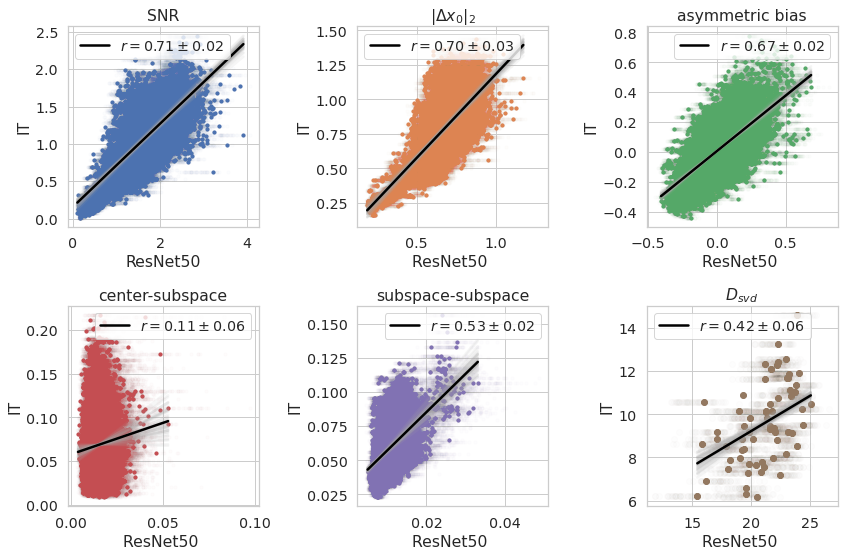

In [1511]:
plt.figure(figsize=(12,8))

plt.subplot(231)
x = SNR_rn[~mask]
y = SNR_IT[~mask]
plt.scatter(x,y,color='C0',s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_SNR)*xx+np.mean(b_SNR), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_SNR),np.std(r_SNR)))
for mm,bb,SNR_rn_tmp in zip(m_SNR,b_SNR,SNR_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(SNR_rn_tmp[~mask],SNR_IT[~mask],color='C0',alpha=0.01, zorder=1,s=10)
plt.legend()
plt.xlabel('ResNet50')
plt.ylabel('IT')
plt.title('SNR')

plt.subplot(232)
x = dist_norm_rn[~mask]
y = dist_norm_IT[~mask]
plt.scatter(x,y,color='C1', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_dist)*xx+np.mean(b_dist), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_dist),np.std(r_dist)))
for mm,bb,dist_rn_tmp in zip(m_dist,b_dist,dist_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(dist_rn_tmp[~mask],dist_norm_IT[~mask],color='C1',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('$\|\Delta x_0\|_2$')

plt.subplot(233)
x = bias_rn[~mask]
y = bias_IT[~mask]
plt.scatter(x,y,color='C2', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_bias)*xx+np.mean(b_bias), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_bias),np.std(r_bias)))
for mm,bb,bias_rn_tmp in zip(m_bias,b_bias,bias_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(bias_rn_tmp[~mask],bias_IT[~mask],color='C2',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('asymmetric bias')

plt.subplot(234)
x = csa_rn[~mask]
y = csa_IT[~mask]
m,b = np.polyfit(x,y,1)
plt.scatter(x,y,color='C3', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_cs)*xx+np.mean(b_cs), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_cs),np.std(r_cs)))
for mm,bb,cs_rn_tmp in zip(m_cs,b_cs,cs_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(cs_rn_tmp[~mask],csa_IT[~mask],color='C3',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('center-subspace')

plt.subplot(235)
x = ss_rn[~mask]
y = ss_IT[~mask]
plt.scatter(x,y,color='C4', s=10)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_ss)*xx+np.mean(b_ss), c='black',
         label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_ss),np.std(r_ss)))
for mm,bb,ss_rn_tmp in zip(m_ss,b_ss,ss_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(ss_rn_tmp[~mask],ss_IT[~mask],color='C4',alpha=0.01, zorder=1, s=10)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title('subspace-subspace')

plt.subplot(236)
x = Ds_rn
y = Ds_IT
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,np.mean(m_D)*xx+np.mean(b_D), c='black', label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_D),np.std(r_D)))
for mm,bb,Ds_rn_tmp in zip(m_D,b_D,Ds_rn_all):
    plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
    plt.scatter(Ds_rn_tmp,Ds_IT,color='C5',alpha=0.01, zorder=1)
plt.legend()
plt.xlabel('ResNet50 ')
plt.ylabel('IT')
plt.title(r'$D_{svd}$')
plt.tight_layout()

plt.savefig('images/resnet_vs_IT_geometry.png', dpi=1000)

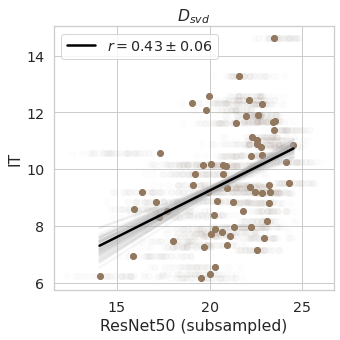

In [1490]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(5,5))
    plt.scatter(Ds_rn,Ds_IT,color='C5')
    xx = np.linspace(np.min(Ds_rn),np.max(Ds_rn),100)
    plt.plot(xx,m*xx+b, c='black', label=r'$r={:.2f}\pm{:.2f}$'.format(np.mean(r_D),np.std(r_D)))
    for mm,bb,Ds_rn_tmp in zip(m_D,b_D,Ds_rn_all):
        plt.plot(xx,mm*xx+bb, c='darkgrey', zorder=1, alpha=0.1)
        plt.scatter(Ds_rn_tmp,Ds_IT,color='C5',alpha=0.01, zorder=1)
    plt.legend()
    plt.xlabel('ResNet50 (subsampled)')
    plt.ylabel('IT')
    plt.title(r'$D_{svd}$')
    plt.tight_layout()

(array([ 2.,  0.,  6., 16., 15., 19., 21., 15.,  4.,  2.]),
 array([0.24985336, 0.28234573, 0.3148381 , 0.34733047, 0.37982284,
        0.41231521, 0.44480758, 0.47729995, 0.50979232, 0.54228469,
        0.57477706]),
 <BarContainer object of 10 artists>)

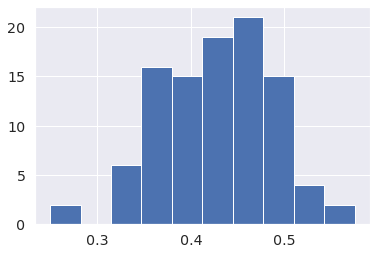

In [1448]:
plt.hist(r_D)

In [1440]:
np.mean(r_ss)

0.5359562712556252

In [1444]:
np.mean(p_cs)

0.025832202454931806

In [1437]:
np.mean(r_D)

0.41886063677430463

In [1438]:
np.mean(p_D)

0.002568774143466931

In [1424]:
p_D = np.stack(p_D)

In [1425]:
r_D = np.stack(r_D)

In [1427]:
np.mean(r_D[p_D<1e-2])

0.4151869893790945

(array([ 3.,  4.,  3., 10., 11.,  8.,  6.,  2.,  1.,  2.]),
 array([0.32135344, 0.34418474, 0.36701604, 0.38984734, 0.41267864,
        0.43550994, 0.45834123, 0.48117253, 0.50400383, 0.52683513,
        0.54966643]),
 <BarContainer object of 10 artists>)

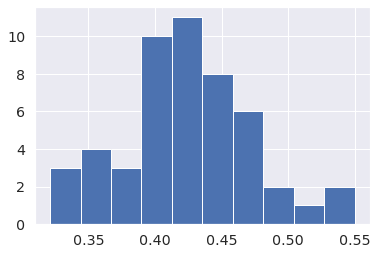

In [1435]:
plt.hist(r_D)

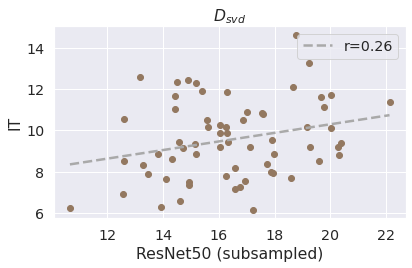

In [1408]:
x = Ds_rn
y = Ds_IT
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50 (subsampled)')
plt.ylabel('IT')
plt.title(r'$D_{svd}$')
plt.tight_layout()

In [1406]:
p_D

[0.03581341721883074]

In [1401]:
m,b,r,p,stderr = linregress(x,y)

In [1402]:
p

0.008293844753585165

In [1008]:
p

0.0024017870795353968

## Compressed sensing

In [1001]:
M_IT = 168
Ds0_IT = (M_IT*Ds_IT-1)/ (M_IT-Ds_IT)

In [1002]:
M_rn = 2048
Ds0_rn = (M_rn*Ds_rn-1)/ (M_rn-Ds_rn)

In [149]:
N = 2048
Ms = np.logspace(5,11,10,base=2)
n_avg = 5
Dsvds = []
for M in tqdm(Ms):
    Dmean = []
    for _ in range(n_avg):
        A = np.random.randn(N,int(M)) / np.sqrt(M)
        manifolds_small = manifolds_resnet@A 
        for manifold in manifolds_small:
            center = manifold.mean(0)
            _,R,U = np.linalg.svd(manifold - center)
            Dsvd = np.sum(R**2)**2 / np.sum(R**4)
            Dsvds.append(Dsvd)
Dsvds = np.stack(Dsvds).reshape(len(Ms),n_avg,K).mean(1)
# C2s = np.stack(C2s).reshape(len(Ms),n_avg).mean(-1)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [150]:
N = 168
Ms = np.logspace(5,7,3,base=2)
n_avg = 50
Dsvds_IT = []
for M in tqdm(Ms):
    for _ in range(n_avg):
        A = np.random.randn(N,int(M)) / np.sqrt(M)
        manifolds_small = manifolds@A 
#         idxs = np.random.choice(N,int(M),replace=False)
#         manifolds_small = manifolds[:,:,idxs]
        for manifold in manifolds_small:
            center = manifold.mean(0)
            _,R,U = np.linalg.svd(manifold - center)
            Dsvd = np.sum(R**2)**2 / np.sum(R**4)
            Dsvds_IT.append(Dsvd)
Dsvds_IT = np.stack(Dsvds_IT).reshape(len(Ms),n_avg,K).mean(1)
# C2s = np.stack(C2s).reshape(len(Ms),n_avg).mean(-1)

/home/bsorsch/.py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


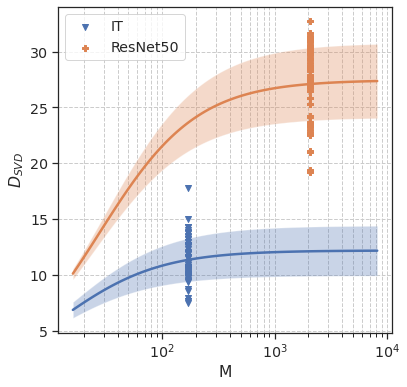

In [1003]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(4,13,100, base=2)
    Ds_IT_pred = Ds0_IT / (1+Ds0_IT/Ms[:,None])
    plt.plot(Ms, Ds_IT_pred.mean(1));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)
    Ds_IT_pred = Ds0_rn / (1+Ds0_rn/Ms[:,None])
    plt.plot(Ms, Ds0_rn.mean() / (1+Ds0_rn.mean()/Ms[:,None]));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)

    plt.xscale('log')
    plt.scatter(M_IT*np.ones(len(Ds_IT)), Ds_IT, color='C0', marker='v', label='IT')
    plt.scatter(M_rn*np.ones(len(Ds_rn)), Ds_rn, color='C1', marker='P', label='ResNet50')
    # plt.yscale('log')

#     Ms = np.logspace(5,11,10,base=2)
#     plt.scatter(Ms, Dsvds.mean(1), color='C1')
    
#     Ms = np.logspace(5,7,3,base=2)
#     plt.scatter(Ms, Dsvds_IT.mean(1), color='C0')

    plt.xlabel('M')
    plt.ylabel(r'$D_{SVD}$')
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_D.pdf')

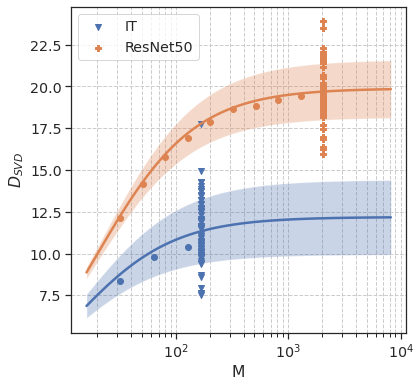

In [151]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(4,13,100, base=2)
    Ds_IT_pred = Ds0_IT / (1+Ds0_IT/Ms[:,None])
    plt.plot(Ms, Ds_IT_pred.mean(1));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)
    Ds_IT_pred = Ds0_rn / (1+Ds0_rn/Ms[:,None])
    plt.plot(Ms, Ds0_rn.mean() / (1+Ds0_rn.mean()/Ms[:,None]));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)

    plt.xscale('log')
    plt.scatter(M_IT*np.ones(len(Ds_IT)), Ds_IT, color='C0', marker='v', label='IT')
    plt.scatter(M_rn*np.ones(len(Ds_rn)), Ds_rn, color='C1', marker='P', label='ResNet50')
    # plt.yscale('log')

    Ms = np.logspace(5,11,10,base=2)
    plt.scatter(Ms, Dsvds.mean(1), color='C1')
    
    Ms = np.logspace(5,7,3,base=2)
    plt.scatter(Ms, Dsvds_IT.mean(1), color='C0')

    plt.xlabel('M')
    plt.ylabel(r'$D_{SVD}$')
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_D.pdf')

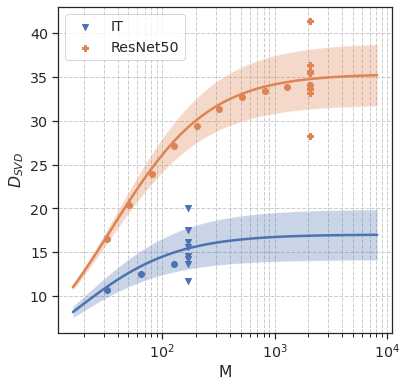

In [974]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(4,13,100, base=2)
    Ds_IT_pred = Ds0_IT / (1+Ds0_IT/Ms[:,None])
    plt.plot(Ms, Ds_IT_pred.mean(1));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)
    Ds_IT_pred = Ds0_rn / (1+Ds0_rn/Ms[:,None])
    plt.plot(Ms, Ds0_rn.mean() / (1+Ds0_rn.mean()/Ms[:,None]));
    plt.fill_between(Ms, Ds_IT_pred.mean(1) + Ds_IT_pred.std(1),
                         Ds_IT_pred.mean(1) - Ds_IT_pred.std(1), alpha=0.3)

    plt.xscale('log')
    plt.scatter(M_IT*np.ones(len(Ds_IT)), Ds_IT, color='C0', marker='v', label='IT')
    plt.scatter(M_rn*np.ones(len(Ds_rn)), Ds_rn, color='C1', marker='P', label='ResNet50')
    # plt.yscale('log')

    Ms = np.logspace(5,11,10,base=2)
    plt.scatter(Ms, Dsvds.mean(1), color='C1')
    
    Ms = np.logspace(5,7,3,base=2)
    plt.scatter(Ms, Dsvds_IT.mean(1), color='C0')

    plt.xlabel('M')
    plt.ylabel(r'$D_{SVD}$')
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_D.pdf')

In [1004]:
SNR0_rn = SNR_rn*np.sqrt(1+Ds0_rn/2048)

In [1005]:
SNR0_IT = SNR_IT*np.sqrt(1+Ds0_IT/168)

No handles with labels found to put in legend.


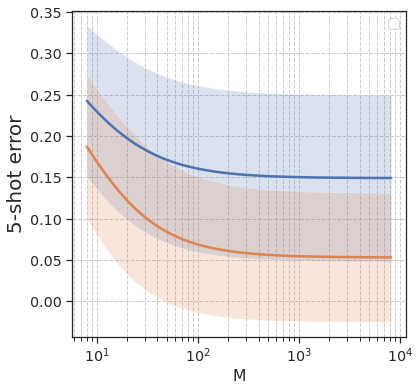

In [1006]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(3,13,100, base=2)

    SNR_IT_pred = SNR0_IT / np.sqrt(1+Ds0_IT / Ms[:,None,None])
    err_IT_pred = H(SNR_IT_pred)
    plt.plot(Ms, np.nanmean(err_IT_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_IT_pred,(1,2)) + np.nanstd(err_IT_pred,(1,2)),
                    np.nanmean(err_IT_pred,(1,2)) - np.nanstd(err_IT_pred,(1,2)),alpha=0.2)

    SNR_rn_pred = SNR0_rn / np.sqrt(1+Ds0_rn / Ms[:,None,None])
    err_rn_pred = H(SNR_rn_pred)
    plt.plot(Ms, np.nanmean(err_rn_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_rn_pred,(1,2)) + np.nanstd(err_rn_pred,(1,2)),
                    np.nanmean(err_rn_pred,(1,2)) - np.nanstd(err_rn_pred,(1,2)),alpha=0.2)

#     plt.scatter(M_IT*np.ones((K,K)), H(SNR_IT), color='C0', marker='v', label='IT')
#     plt.scatter(M_rn*np.ones((K,K)), H(SNR_rn), color='C1', marker='P', label='ResNet50')

    plt.xscale('log')
    plt.xlabel('M')
    plt.ylabel('5-shot error', fontsize=20)
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_err_5shot.pdf')

No handles with labels found to put in legend.


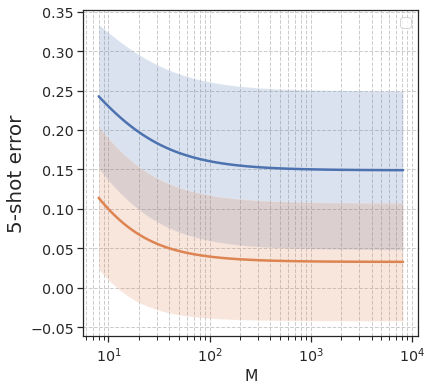

In [155]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(3,13,100, base=2)

    SNR_IT_pred = SNR0_IT / np.sqrt(1+Ds0_IT / Ms[:,None,None])
    err_IT_pred = H(SNR_IT_pred)
    plt.plot(Ms, np.nanmean(err_IT_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_IT_pred,(1,2)) + np.nanstd(err_IT_pred,(1,2)),
                    np.nanmean(err_IT_pred,(1,2)) - np.nanstd(err_IT_pred,(1,2)),alpha=0.2)

    SNR_rn_pred = SNR0_rn / np.sqrt(1+Ds0_rn / Ms[:,None,None])
    err_rn_pred = H(SNR_rn_pred)
    plt.plot(Ms, np.nanmean(err_rn_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_rn_pred,(1,2)) + np.nanstd(err_rn_pred,(1,2)),
                    np.nanmean(err_rn_pred,(1,2)) - np.nanstd(err_rn_pred,(1,2)),alpha=0.2)

#     plt.scatter(M_IT*np.ones((K,K)), H(SNR_IT), color='C0', marker='v', label='IT')
#     plt.scatter(M_rn*np.ones((K,K)), H(SNR_rn), color='C1', marker='P', label='ResNet50')

    plt.xscale('log')
    plt.xlabel('M')
    plt.ylabel('5-shot error', fontsize=20)
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_err_5shot.pdf')

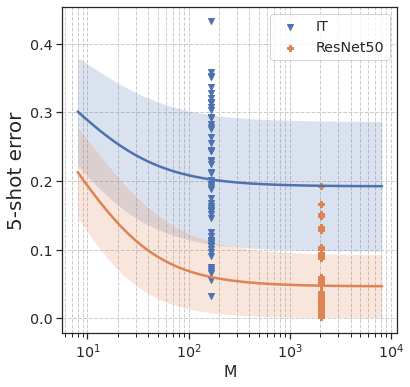

In [976]:
plt.figure(figsize=(6,6))
with sns.axes_style('ticks'):
    Ms = np.logspace(3,13,100, base=2)

    SNR_IT_pred = SNR0_IT / np.sqrt(1+Ds0_IT / Ms[:,None,None])
    err_IT_pred = H(SNR_IT_pred)
    plt.plot(Ms, np.nanmean(err_IT_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_IT_pred,(1,2)) + np.nanstd(err_IT_pred,(1,2)),
                    np.nanmean(err_IT_pred,(1,2)) - np.nanstd(err_IT_pred,(1,2)),alpha=0.2)

    SNR_rn_pred = SNR0_rn / np.sqrt(1+Ds0_rn / Ms[:,None,None])
    err_rn_pred = H(SNR_rn_pred)
    plt.plot(Ms, np.nanmean(err_rn_pred,(1,2)))
    plt.fill_between(Ms, np.nanmean(err_rn_pred,(1,2)) + np.nanstd(err_rn_pred,(1,2)),
                    np.nanmean(err_rn_pred,(1,2)) - np.nanstd(err_rn_pred,(1,2)),alpha=0.2)

    plt.scatter(M_IT*np.ones((K,K)), H(SNR_IT), color='C0', marker='v', label='IT')
    plt.scatter(M_rn*np.ones((K,K)), H(SNR_rn), color='C1', marker='P', label='ResNet50')

    plt.xscale('log')
    plt.xlabel('M')
    plt.ylabel('5-shot error', fontsize=20)
    plt.grid(True, which='both',ls='--')
    plt.legend()
# plt.savefig('manifold/images/random_proj_err_5shot.pdf')

## Regress neural response

In [876]:
manifolds.shape

(64, 50, 168)

In [879]:
X_IT = manifolds[:,:25].reshape(25*K, 168)
X_rn = manifolds_resnet[:,:25].reshape(25*K, 2048)

Y_IT = manifolds[:,25:].reshape(25*K, 168)
Y_rn = manifolds_resnet[:,25:].reshape(25*K, 2048)

In [880]:
W, resid, rank, s = np.linalg.lstsq(X_rn, X_IT, rcond=None)

In [881]:
Y_IT_hat = Y_rn@W

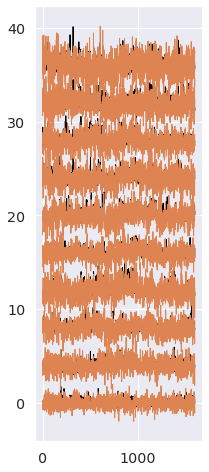

In [882]:
plt.figure(figsize=(3,8))
for i in range(10):
    plt.plot(Y_IT[:,i] + 4*i, c='black', linewidth=1)
    plt.plot(Y_IT_hat[:,i] + 4*i, c='C1', linewidth=1)

In [883]:
np.corrcoef(Y_IT.ravel(), Y_IT_hat.ravel())

array([[1.        , 0.26634212],
       [0.26634212, 1.        ]])

In [815]:
X_IT_hat.shape

(3200, 168)

In [816]:
manifolds.shape

(64, 50, 168)

In [817]:
K

64

In [818]:
manifolds_hat = X_IT_hat.reshape(K,P,168)

In [819]:
Rs = []
centers = []
Us = []
for manifold in manifolds_hat:
    centers.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs.append(R)
    Us.append(V)
Rs = np.stack(Rs)
centers = np.stack(centers)
Us = np.stack(Us)

In [820]:
m = 5
dist_norm_hat, Ds_hat, csa_hat, ss_hat, SNR_hat = geometry(centers,Rs,Us,m)

In [821]:
Ds_rn

array([20.2316  , 20.657354, 18.163694, 23.492775, 21.654781, 19.314764,
       23.896961, 18.520935, 19.121643, 18.566746, 16.857033, 18.37035 ,
       16.985012, 16.235804, 17.465101, 17.696796, 19.324871, 19.127966,
       19.144602, 16.348219, 19.663353, 18.918583, 15.980458, 19.065615,
       19.989702, 21.39588 , 21.465984, 22.076399, 20.690823, 19.212915,
       21.56703 , 19.071352, 18.765226, 19.940542, 21.653856, 21.429214,
       21.143248, 19.736835, 21.40297 , 19.610023, 19.66666 , 19.05889 ,
       19.616098, 21.15195 , 20.518423, 20.088797, 21.746662, 21.904785,
       21.896538, 19.46108 , 22.033318, 19.800247, 19.289352, 19.200874,
       18.809143, 18.34127 , 18.68455 , 19.111506, 16.924572, 18.32231 ,
       19.769318, 22.323254, 18.179369, 20.501465], dtype=float32)

In [822]:
Ds_hat

array([ 9.361095 ,  9.580206 ,  8.328099 ,  9.092044 , 11.212441 ,
       10.677461 ,  9.026969 , 12.154115 , 16.066723 , 12.1593685,
       10.316606 , 14.014026 , 13.02559  , 13.738906 , 12.955071 ,
       13.006874 , 12.785084 , 13.026717 , 10.670739 , 12.409496 ,
       10.341418 , 11.678596 , 11.376545 , 11.664313 ,  8.02291  ,
       10.485044 ,  9.008299 , 10.517415 ,  6.473473 ,  9.01591  ,
        9.1117525,  9.691217 ,  7.610132 , 10.745886 ,  9.939129 ,
        8.205926 ,  9.082421 ,  8.992634 ,  8.458959 , 10.584222 ,
       11.798363 , 11.094974 , 12.141903 , 10.210721 , 10.33798  ,
        9.396976 ,  9.405789 ,  7.744087 ,  8.940467 ,  9.877114 ,
       10.470698 , 11.826954 , 11.206148 ,  9.479012 , 10.085885 ,
       10.199727 ,  9.441376 , 10.202692 ,  9.324214 , 12.322414 ,
       11.63632  ,  9.212679 ,  9.637425 , 10.660953 ], dtype=float32)

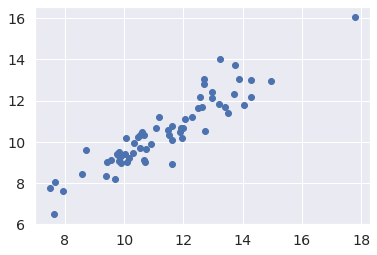

In [824]:
plt.scatter(Ds_IT, Ds_hat)

## before/after avgpool

In [1156]:
manifolds_resnet = np.load('data/dicarlo_shallow_resnet_manifolds.npy')
manifolds_resnet = manifolds_resnet.reshape(3200,2048)[medvar_idxs].reshape(K,-1,2048)

Rs_rn = []
centers_rn = []
Us_rn = []
for manifold in manifolds_resnet:
    centers_rn.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_rn.append(R)
    Us_rn.append(V)
Rs_rn = np.stack(Rs_rn)
centers_rn = np.stack(centers_rn)
Us_rn = np.stack(Us_rn)

_, Ds_pre, _, _, _ = geometry(centers_rn,Rs_rn,Us_rn,m)

In [1157]:
manifolds_resnet = np.load('data/dicarlo_resnet_manifolds.npy')
manifolds_resnet = manifolds_resnet.reshape(3200,2048)[medvar_idxs].reshape(K,-1,2048)

Rs_rn = []
centers_rn = []
Us_rn = []
for manifold in manifolds_resnet:
    centers_rn.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_rn.append(R)
    Us_rn.append(V)
Rs_rn = np.stack(Rs_rn)
centers_rn = np.stack(centers_rn)
Us_rn = np.stack(Us_rn)

_, Ds_post, _, _, _ = geometry(centers_rn,Rs_rn,Us_rn,m)

Text(0.5, 1.0, '$D_{svd}$')

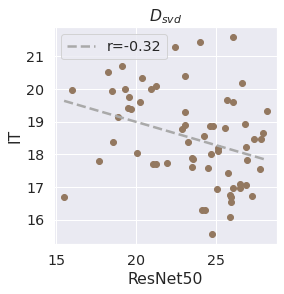

In [1160]:
plt.figure(figsize=(4,4))
x = Ds_pre
y = Ds_post
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('ResNet50')
plt.ylabel('IT')
plt.title(r'$D_{svd}$')

Text(0.5, 1.0, '$D_{svd}$')

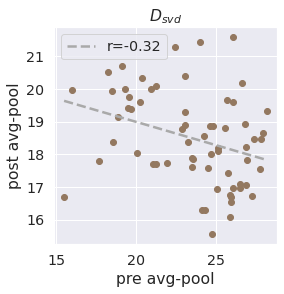

In [1284]:
plt.figure(figsize=(4,4))
x = Ds_pre
y = Ds_post
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('pre avg-pool')
plt.ylabel('post avg-pool')
plt.title(r'$D_{svd}$')

# Asymmetric examples

In [639]:
err_IT.shape

(8, 8)

In [640]:
K = 8
i1,i2 = np.unravel_index(np.flip(np.argsort((err_IT - err_IT.T).ravel())), (K,K))

In [667]:
P = 400
def plot_single(idx):
    i = np.random.choice(400)
    image_path = stimulus_set.get_image(stimulus_set['image_id'][cat_idxs[idx][i]])
    img = image.imread(image_path)
    plt.imshow(img)
    plt.axis('off')

In [673]:
from IPython.display import clear_output

In [676]:
len(i1)

64

In [689]:
np.random.choice(np.arange(8,16))

12

In [ ]:
guesses = []
idxs = []
flip1s = []
flip2s = []
for j in range(100):
    clear_output()
    print(j)
    plt.figure(figsize=(14,10))
    i = np.random.choice(np.arange(8,16))
    flip1 = np.random.choice(2)
    flip2 = np.random.choice(2)
    plt.subplot(231)
    if flip1:
        plot_single(i2[i])
    else:
        plot_single(i1[i])
    plt.subplot(233)
    if flip1:
        plot_single(i1[i])
    else:
        plot_single(i2[i])
    plt.subplot(235)
    if flip2:
        plot_single(i2[i])
    else:
        plot_single(i1[i])
    
    
    plt.pause(0.001)
    guess = input()
    idxs.append(i)
    guesses.append(int(guess))
    flip1s.append(flip1)
    flip2s.append(flip2)
flip1s = np.stack(flip1s)
flip2s = np.stack(flip2s)

# Chabo vs Tito

In [1303]:
features = compact_data.values

manifolds = []
for ci in class_idxs:
    manifolds.append(features[ci])
manifolds = np.stack(manifolds)

In [686]:
# # Try z-scoring
# mu = manifolds.mean((0,1))
# std = manifolds.std((0,1))

# manifolds = (manifolds - mu) / std

In [1304]:
manifolds_chabo = manifolds[:,:,:58]
manifolds_tito = manifolds[:,:,58:]

In [1514]:
# # A = np.random.randn(2048,58)/np.sqrt(58)
# # manifolds_chabo = manifolds_resnet@A
# # A = np.random.randn(2048,58)/np.sqrt(58)
# # manifolds_tito = manifolds_resnet@A

idxs = np.random.choice(np.arange(2048),158,replace=False)
manifolds_chabo = manifolds_resnet[:,:,idxs]
idxs = np.random.choice(np.arange(2048),158,replace=False)
manifolds_tito = manifolds_resnet[:,:,idxs]

In [1515]:
Rs_chabo = []
centers_chabo = []
Us_chabo = []
idxs = np.random.choice(manifolds_chabo.shape[-1], 58, replace=False)
for manifold in manifolds_chabo:
    centers_chabo.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_chabo.append(R)
    Us_chabo.append(V)
Rs_chabo = np.stack(Rs_chabo)
centers_chabo = np.stack(centers_chabo)
Us_chabo = np.stack(Us_chabo)

In [1516]:
Rs_tito = []
centers_tito = []
Us_tito = []
idxs = np.random.choice(manifolds_tito.shape[-1], 58)
for manifold in manifolds_tito:
    centers_tito.append(manifold.mean(0))
    U,R,V = np.linalg.svd(manifold - manifold.mean(0),full_matrices=False)
    Rs_tito.append(R)
    Us_tito.append(V)
Rs_tito = np.stack(Rs_tito)
centers_tito = np.stack(centers_tito)
Us_tito = np.stack(Us_tito)

In [1517]:
dist_norm_tito, Ds_tito, csa_tito, ss_tito, SNR_tito = geometry(
    centers_tito,Rs_tito,Us_tito,m)

In [1518]:
dist_norm_chabo, Ds_chabo, csa_chabo, ss_chabo, SNR_chabo = geometry(
    centers_chabo,Rs_chabo,Us_chabo,m)

In [1519]:
bias_chabo = (Rs_chabo**2).sum(-1)[:,None] / (Rs_chabo**2).sum(-1) - 1
bias_tito = (Rs_tito**2).sum(-1)[:,None] / (Rs_tito**2).sum(-1) - 1

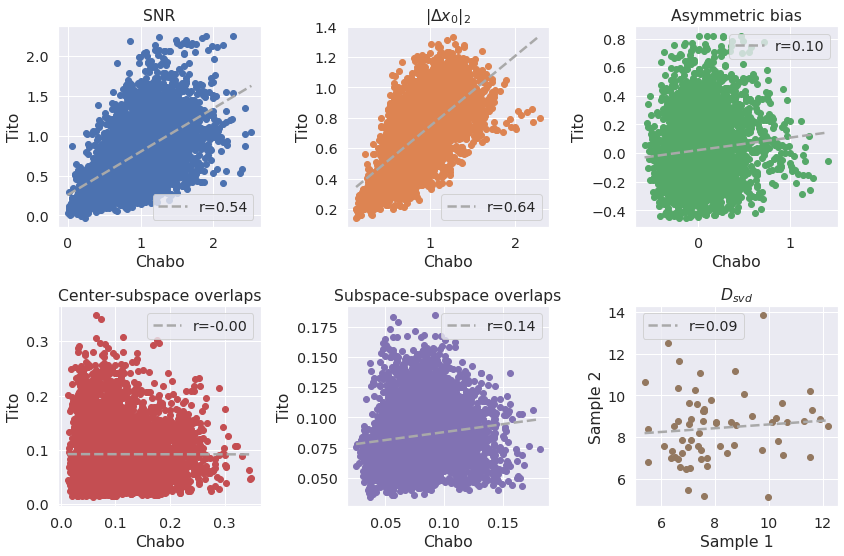

In [1317]:
plt.figure(figsize=(12,8))

plt.subplot(231)
x = SNR_chabo[~mask]
y = SNR_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Chabo')
plt.ylabel('Tito')
plt.title('SNR')

plt.subplot(232)
x = dist_norm_chabo[~mask]
y = dist_norm_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y, color='C1')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Chabo')
plt.ylabel('Tito')
plt.title('$\|\Delta x_0\|_2$')

plt.subplot(233)
x = bias_chabo[~mask]
y = bias_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C2')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Chabo')
plt.ylabel('Tito')
plt.title('Asymmetric bias')

plt.subplot(234)
x = csa_chabo[~mask]
y = csa_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C3')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Chabo')
plt.ylabel('Tito')
plt.title('Center-subspace overlaps')

plt.subplot(235)
x = ss_chabo[~mask]
y = ss_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C4')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Chabo')
plt.ylabel('Tito')
plt.title('Subspace-subspace overlaps')
plt.tight_layout()

plt.subplot(236)
x = Ds_chabo
y = Ds_tito
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title(r'$D_{svd}$')
plt.tight_layout()

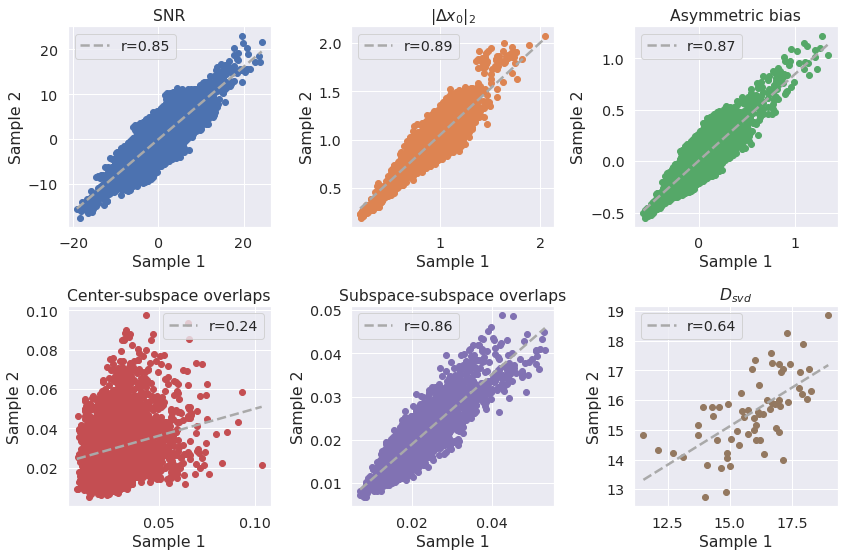

In [1282]:
plt.figure(figsize=(12,8))

plt.subplot(231)
x = SNR_chabo[~mask]
y = SNR_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y)
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title('SNR')

plt.subplot(232)
x = dist_norm_chabo[~mask]
y = dist_norm_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y, color='C1')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title('$\|\Delta x_0\|_2$')

plt.subplot(233)
x = bias_chabo[~mask]
y = bias_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C2')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title('Asymmetric bias')

plt.subplot(234)
x = csa_chabo[~mask]
y = csa_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C3')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title('Center-subspace overlaps')

plt.subplot(235)
x = ss_chabo[~mask]
y = ss_tito[~mask]
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C4')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title('Subspace-subspace overlaps')
plt.tight_layout()

plt.subplot(236)
x = Ds_chabo
y = Ds_tito
m,b = np.polyfit(x,y,1)
r = np.corrcoef(x,y)[0,1]
plt.scatter(x,y,color='C5')
xx = np.linspace(np.min(x),np.max(x),100)
plt.plot(xx,m*xx+b, c='darkgrey', linestyle='dashed', label='r={:.2f}'.format(r))
plt.legend()
plt.xlabel('Sample 1')
plt.ylabel('Sample 2')
plt.title(r'$D_{svd}$')
plt.tight_layout()

# Imnames for resnet

In [105]:
compact_data = neural_data.multi_groupby(
    ['category_name', 'object_name', 'image_id']).mean(dim='presentation')  # (1)
compact_data = compact_data.sel(region='IT')  # (2)
compact_data = compact_data.squeeze('time_bin')  # (3)
compact_data = compact_data.transpose('presentation', 'neuroid')  # (4)
compact_data

/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: list(self.group_coord_names)})


<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (presentation: 3200, neuroid: 168)>
array([[ 0.1962  ,  0.10559 ,  0.430899, ...,  0.254563, -0.103698,  0.400337],
       [-0.188017, -0.599624, -0.02469 , ...,  0.108069,  0.243771,  0.13458 ],
       [ 0.576654,  0.242336, -0.229085, ...,  0.312417, -0.155798,  0.012417],
       ...,
       [ 0.608051,  0.17681 , -0.110604, ...,  0.123359,  0.14819 ,  0.076451],
       [ 0.014948, -0.243371, -0.238544, ...,  0.593095,  0.112013, -0.267446],
       [-0.107264, -0.029414, -0.074609, ..., -0.297466,  0.482114,  0.243566]],
      dtype=float32)
Coordinates:
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) object 'Chabo_L_M_5_9' ... 'Chabo_L_A_4_4'
  - arr            (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'A' 'A' 'A' 'A' 'A'
  - col            (neuroid) int64 9 9 8 9 8 8 7 7 5 6 4 ... 5 6 4 5 3 4 5 4 5 4
  - hemisphere     (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion      (n

In [110]:
imnames = compact_data['image_id'].values

In [112]:
np.save('data/majaj_2015_imnames_2.npy', imnames)

In [106]:
class_labels = compact_data['category_name'].values
labels = compact_data['object_name'].values

In [107]:
uniq_classes = np.unique(class_labels)
uniq_labels,idxs = np.unique(labels, return_index=True)
uniq_labels = uniq_labels[np.argsort(idxs)]
print(uniq_labels)

['bear' 'cow' 'dog' 'elephant' 'gorilla' 'hedgehog' 'lioness' 'turtle'
 'ship0' 'ship1' 'ship2' 'ship3' 'ship4' 'ship5' 'ship6' 'ship7'
 'car_alfa' 'car_astra' 'car_beetle' 'car_bmw' 'car_bora' 'car_celica'
 'car_clio' 'car_z3' 'chair0' 'chair1' 'chair2' 'chair3' 'chair4' 'chair5'
 'chair6' 'chair7' 'face0' 'face1' 'face2' 'face3' 'face4' 'face5' 'face6'
 'face7' 'apple' 'apricot' 'peach' 'pear' 'raspberry' 'strawberry'
 'walnut' 'watermelon' 'airplane0' 'airplane1' 'airplane2' 'airplane3'
 'airplane4' 'airplane5' 'airplane6' 'airplane7' 'table0' 'table1'
 'table2' 'table3' 'table4' 'table5' 'table6' 'table7']


In [108]:
class_idxs = []
for lbl in uniq_labels:
    class_idxs.append(np.where(np.stack(labels)==lbl)[0])

In [109]:
compact_data['image_id'].values[:20]

array(['00487445258f44c4de1c0a681a21e618c9e148f8',
       '019dcae93081e4d8c3584c63d731835da84966cf',
       '092a52b95af8241400770e637966905b3afec7e2',
       '0a88717566717c21d88d73ace9fd6c765fdf1a45',
       '0b167da9e814adc1eabc95dabcffc1fb9d802b18',
       '0ffccc28b72bc5b7fece0a0447e6efc847494050',
       '1045cadfd4b3fafc15cad9de36534e6c62d0695c',
       '12b40e3a282485d4ece760ff646bf88ad16c62d1',
       '1303602bbc2f8a67901449573b9180659f3cbd6e',
       '19cad7de0f427f39d3dfaa714bb061be107c5d23',
       '1ab356f76618484855c18fb5c4fd13ae24d517c0',
       '1cb5333e7a6da4c5bfffc6ae0fc56bf0623a1588',
       '28b903af5db5a703437b44715c81ef50f8b3e897',
       '2caa873be61d738027c9589b484683268cf5fccd',
       '2cfc76b59cb12d02b58554b90439aa7970a3784f',
       '2e252d189cb329d64a7090907ecfcbb4b8d7983e',
       '2e7329a589c41e4785704bc759887fff96f1d901',
       '34a4e379f5e9ef97509757b7558be4ac8ec03e45',
       '3cda2a1b8b0b2790d9fbc595c0064de7657b288e',
       '3ff5c84ce4aa301a3789cc0

# Brain score

In [1117]:
manifolds_shallow_resnet = np.load('data/dicarlo_shallow_resnet152_manifolds.npy')

In [1118]:
from brainio_base.assemblies import NeuroidAssembly

In [1119]:
N = manifolds_shallow_resnet.shape[-1]
assembly_resnet = NeuroidAssembly(manifolds_shallow_resnet.reshape(3200,N),
                           coords={'image_id': ('presentation', compact_data['image_id'].values),
                                   'object_name': ('presentation', compact_data['object_name'].values),
                                   'neuroid_id': ('neuroid', np.arange(N))},
                           dims=['presentation', 'neuroid'])

/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [1120]:
prediction, target = assembly_resnet, compact_data 

In [1121]:
from brainscore.metrics.regression import CrossRegressedCorrelation, pls_regression, pearsonr_correlation

regression = pls_regression()  # 1: define the regression
correlation = pearsonr_correlation()  # 2: define the correlation
metric = CrossRegressedCorrelation(regression, correlation)  # 3: wrap in cross-validation

In [1122]:
score = metric(source=prediction, target=target)

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)
cross-validation:  10%|█         | 1/10 [00:06<00:57,  6.43s/it]/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)
cross-validation:  20%|██        | 2/10 [00:12<00:49,  6.22s/it]/home/bsorsch/.py37/lib/python3.7/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)
cross-validation:  30%|███       | 3/10 [00:18<00:44,  6.32s/it]/home/bsorsch/

In [1123]:
print('wide resnet feature layer')
print(score)

wide resnet feature layer
<xarray.Score (aggregation: 2)>
array([0.552808, 0.00423 ])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.290969, 0.4...


In [991]:
print(score)

<xarray.Score (aggregation: 2)>
array([0.548418, 0.003938])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.355271, 0.4...


In [976]:
print(score)

<xarray.Score (aggregation: 2)>
array([0.550133, 0.004912])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.336907, 0.4...


In [961]:
print(score)

<xarray.Score (aggregation: 2)>
array([0.515212, 0.004702])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.32671 , 0.3...


In [933]:
print(score)

<xarray.Score (aggregation: 2)>
array([0.527868, 0.002982])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.287573, 0.4...


In [922]:
print(score)

<xarray.Score (aggregation: 2)>
array([0.514008, 0.005066])
Coordinates:
  * aggregation  (aggregation) <U6 'center' 'error'
Attributes:
    raw:      <xarray.Score (split: 10, neuroid: 168)>\narray([[0.332035, 0.4...


In [923]:
print(score.raw)

<xarray.Score (split: 10, neuroid: 168)>
array([[0.332035, 0.422738, 0.489855, ..., 0.600091, 0.567888, 0.661258],
       [0.368766, 0.499058, 0.513715, ..., 0.635717, 0.529674, 0.644338],
       [0.351818, 0.50942 , 0.517733, ..., 0.631568, 0.569041, 0.63674 ],
       ...,
       [0.151111, 0.504988, 0.502864, ..., 0.580818, 0.522905, 0.607177],
       [0.253341, 0.340548, 0.38797 , ..., 0.561071, 0.618399, 0.662787],
       [0.227821, 0.437589, 0.442637, ..., 0.639502, 0.623915, 0.69091 ]])
Coordinates:
  * split       (split) int64 0 1 2 3 4 5 6 7 8 9
  * neuroid     (neuroid) MultiIndex
  - neuroid_id  (neuroid) object 'Chabo_L_A_2_4' ... 'Chabo_L_A_8_4'
  - arr         (neuroid) object 'A' 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
  - col         (neuroid) int64 4 3 5 0 1 2 3 4 5 6 2 ... 6 1 2 3 4 5 6 7 2 3 4
  - hemisphere  (neuroid) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion   (neuroid) object 'cIT' 'cIT' 'aIT' 'cIT' ... 'cIT' 'cIT' 'cIT'
  - animal  